## Food Inspections Evaluation

### Description:
This information is derived from inspections of restaurants in Chicago from January 1, 2013 to April 30, 2019. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program. Inspections are done using a standardized procedure. The results of the inspection are inputted into a database, then reviewed and approved by a State of Illinois Licensed Environmental Health Practitioner (LEHP). A subset of data elements are extracted from this database and downloaded into this data portal.
will find the data gere: https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5

# Problem Statment: 

The aim of this project is to have a predictive model would help by optimize restaurant health inspections for city also reduce the violations of restaurants and contamination of food by taking the impact of the region and the census of housing and whether the restaurant succeed in not taking any violation and what is the probability and seriousness of the violation that will be done.

In [155]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from matplotlib.pyplot import figure
from shapely.geometry import LineString
from descartes import PolygonPatch
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from numpy import median,mean,count_nonzero
# import colorlover as cl
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from collections import Counter
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

In [2]:
# ! conda install plotly

## Executive Summary

We analyzed the data of food violations for restaurants in Chicago  considering 3 factors numbers of crime, and community area. Our goal in the project is to determine the number of crimes and weather conditions. Whether the two conditions are related to making the restaurant take any number of violations.

We noticed that the area is an impact for the violations, so based on that we could predict the rate of violation of the restaurant.

## 1.0 Data Import : 

In [3]:
# Read in datasets from csv to pandas dataframes,
food_inspect_data = pd.read_csv('Data/Food_Inspections.csv')

In [4]:
# Quickly lowercase and camelcase all column names in a DataFrame
# we need to rename columns to use it with SQL later
food_inspect_data = food_inspect_data.rename(columns=lambda x: x.lower().replace(' ', '_').replace('#','').replace('-','_'))

In [209]:
food_inspect_data.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location', 'historical_wards_2003_2015', 'zip_codes',
       'community_areas', 'census_tracts', 'wards'],
      dtype='object')

## 1.1 Datasets Description:

Briefly describe the data: 

|Feature|Type|Dataset|Description|
|---|---|---|---|
|inspection_id|integer|Food_Inspections|Unique identifier for the record| 
|dba_name|object|Food_Inspections|This is legal name of the establishment| 
|aka_name|object|Food_Inspections|This is the name the public would know the establishment as| 
|license_|Float|Food_Inspections|This is a unique number assigned to the establishment for the purposes of licensing by the Department of Business Affairs and Consumer Protection.| 
|facility_type|object|Food_Inspections|Each establishment is described by one of the following:restaurant, bakery, banquet hall, candy store, caterer, coffee shop .. etc| 
|risk|object|Food_Inspections|Risk category of facility with 1 being the highest and 3 the lowest| 
|address, city, state and zip_code of facility|object|Food_Inspections|his is the complete address where the facility is located.| 
|inspection_date|object|Food_Inspections|Date when the inspection occurred| 
|inspection_type|object|Food_Inspections| An inspection can be one of the following types: canvass, the most common type of inspection performed at a frequency relative to the risk of the establishment; consultation, when the inspection is done at the request of the owner prior to the opening of the establishment; complaint, when the inspection is done in response to a complaint against the establishment; license, when the inspection is done as a requirement for the establishment to receive its license to operate; suspect food poisoning, when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint-based inspection); task-force inspection, when an inspection of a bar or tavern is done. Re-inspections can occur for most types of these inspections and are indicated as such| |results|object|Food_Inspections|An inspection can pass, pass with conditions or fail. Establishments receiving a ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15- 29, respectively). Establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a ‘fail’ were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such.| 
|violations|object|Food_Inspections|An establishment can receive one or more of 45 distinct violations (violation numbers 1-44 and 70). For each violation number listed for a given establishment, the requirement the establishment must meet in order for it to NOT receive a violation is noted, followed by a specific description of the findings that caused the violation to be issued|
|latitude_accidents|Float|Food_Inspections|This column present the latitude geographic coordinate of place the inspection| 
|longitude_accidents|object|Food_Inspections|This column present the longitude geographic coordinate of place the inspection| 
|location|object|Food_Inspections|The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal| 
|community_areas|Float|Food_Inspections|Indicates the community area where the incident occurred. Chicago has 77 community areas| 
|census_tracts|Float|Food_Inspections|Census data are tied to the community areas, and they serve as the basis for a variety of urban planning initiatives on both the local and regional levels| 
|wards|Float|Food_Inspections|The ward (City Council district) where the incident occurred|


## 1.3 Display Data:

In [6]:
food_inspect_data.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,results,violations,latitude,longitude,location,historical_wards_2003_2015,zip_codes,community_areas,census_tracts,wards
0,2288224,"LA V BAKERY, INC","LA V BAKERY, INC",2550054.0,Bakery,Risk 2 (Medium),2338 S KEDZIE AVE,CHICAGO,IL,60623.0,...,Out of Business,NaN,41.848790,-87.705311,"(41.84879049508066, -87.70531098155864)",36.0,21569.0,32.0,291.0,1.0
1,2288222,LA TROPICANA FRESH MARKET,LA TROPICANA FRESH MARKET,2663484.0,Grocery Store,Risk 3 (Low),1005 N PULASKI RD,CHICAGO,IL,60651.0,...,Pass,NaN,41.899228,-87.726052,"(41.89922779688617, -87.72605226905087)",41.0,4299.0,24.0,456.0,45.0
2,2286210,GOLDEN SPICE BAKERY,GOLDEN SPICE BAKERY,2663877.0,Bakery,Risk 2 (Medium),2338 S KEDZIE AVE,CHICAGO,IL,60623.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.848790,-87.705311,"(41.84879049508066, -87.70531098155864)",36.0,21569.0,32.0,291.0,1.0
3,2288221,PALETERIA AYUTLA,PALETERIA AYUTLA,2321232.0,Restaurant,Risk 2 (Medium),2404 W 46TH PL,CHICAGO,IL,60632.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.809457,-87.684746,"(41.80945691736228, -87.68474598934672)",29.0,14924.0,55.0,687.0,3.0
4,2288249,SPILT MILK,SPILT MILK,2663633.0,Bakery,Risk 2 (Medium),1844 S BLUE ISLAND AVE,CHICAGO,IL,60608.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.856731,-87.662300,"(41.85673053879921, -87.66229983625918)",8.0,14920.0,33.0,365.0,26.0


In [210]:
food_inspect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186354 entries, 0 to 186353
Data columns (total 22 columns):
inspection_id                 186354 non-null int64
dba_name                      186354 non-null object
aka_name                      183903 non-null object
license                       186338 non-null float64
facility_type                 181603 non-null object
risk                          186279 non-null object
address                       186354 non-null object
city                          186193 non-null object
state                         186320 non-null object
zip                           186275 non-null float64
inspection_date               186354 non-null object
inspection_type               186353 non-null object
results                       186354 non-null object
violations                    136747 non-null object
latitude                      185690 non-null float64
longitude                     185690 non-null float64
location                      185690 n

In [8]:
food_inspect_data.rename(columns={"license_": "license"}, inplace=True)

In [9]:
food_inspect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186354 entries, 0 to 186353
Data columns (total 22 columns):
inspection_id                 186354 non-null int64
dba_name                      186354 non-null object
aka_name                      183903 non-null object
license                       186338 non-null float64
facility_type                 181603 non-null object
risk                          186279 non-null object
address                       186354 non-null object
city                          186193 non-null object
state                         186320 non-null object
zip                           186275 non-null float64
inspection_date               186354 non-null object
inspection_type               186353 non-null object
results                       186354 non-null object
violations                    136747 non-null object
latitude                      185690 non-null float64
longitude                     185690 non-null float64
location                      185690 n

## 1.4 Investigate the Dataset 

In [10]:
#check the shape of our dataset
food_inspect_data.shape

(186354, 22)

In [11]:
# information about dataset
food_inspect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186354 entries, 0 to 186353
Data columns (total 22 columns):
inspection_id                 186354 non-null int64
dba_name                      186354 non-null object
aka_name                      183903 non-null object
license                       186338 non-null float64
facility_type                 181603 non-null object
risk                          186279 non-null object
address                       186354 non-null object
city                          186193 non-null object
state                         186320 non-null object
zip                           186275 non-null float64
inspection_date               186354 non-null object
inspection_type               186353 non-null object
results                       186354 non-null object
violations                    136747 non-null object
latitude                      185690 non-null float64
longitude                     185690 non-null float64
location                      185690 n

In [12]:
# total of missing values in each columns
# Verifying missing data
food_inspect_data.isnull().sum()

inspection_id                     0
dba_name                          0
aka_name                       2451
license                          16
facility_type                  4751
risk                             75
address                           0
city                            161
state                            34
zip                              79
inspection_date                   0
inspection_type                   1
results                           0
violations                    49607
latitude                        664
longitude                       664
location                        664
historical_wards_2003_2015     3300
zip_codes                       664
community_areas                3300
census_tracts                   693
wards                          3300
dtype: int64

In [13]:
food_inspect_data.describe()

,inspection_id,license,zip,latitude,longitude,historical_wards_2003_2015,zip_codes,community_areas,census_tracts,wards
count,1.863540e+05,1.863380e+05,186275.000000,185690.000000,185690.000000,183054.000000,185690.000000,183054.000000,185661.000000,183054.000000
mean,1.401282e+06,1.578144e+06,60629.055633,41.880871,-87.676531,27.563615,17949.851134,37.457089,374.573540,26.924967
std,6.189594e+05,8.934119e+05,22.749563,0.080897,0.058807,14.536148,6301.889133,19.163725,244.326867,13.729340
min,4.424700e+04,0.000000e+00,60007.000000,41.644670,-87.914428,1.000000,4299.000000,1.000000,1.000000,1.000000
25%,1.115189e+06,1.194063e+06,60614.000000,41.833619,-87.707534,16.000000,14917.000000,24.000000,149.000000,16.000000
50%,1.464266e+06,1.964515e+06,60625.000000,41.891689,-87.666419,26.000000,21538.000000,36.000000,358.000000,27.000000
75%,1.970564e+06,2.216068e+06,60643.000000,41.939745,-87.634844,41.000000,22212.000000,55.000000,598.000000,37.000000
max,2.288249e+06,9.999999e+06,60827.000000,42.021064,-87.525094,53.000000,26633.000000,77.000000,801.000000,50.000000


In [14]:
food_inspect_data.facility_type.value_counts()

Restaurant                                    123783
Grocery Store                                  23988
School                                         11860
Children's Services Facility                    2725
Bakery                                          2707
Daycare (2 - 6 Years)                           2637
Daycare Above and Under 2 Years                 2176
Long Term Care                                  1244
Catering                                        1105
Mobile Food Dispenser                            843
Liquor                                           830
Daycare Combo 1586                               780
Mobile Food Preparer                             551
Golden Diner                                     538
Wholesale                                        530
Hospital                                         501
TAVERN                                           252
Daycare (Under 2 Years)                          229
Special Event                                 

# 2.0 Preprocessing and Data Structure

Preparation food inspections data 

Take just we need from dataset :

In [15]:
# Extracting facility_type Restaurant
# Only consider restaurants
food_inspect_data_restaurant = food_inspect_data[food_inspect_data['facility_type'] =='Restaurant']

In [16]:
food_inspect_data_restaurant.shape

(123783, 22)

In [17]:
food_inspect_data_restaurant.facility_type.count()

123783

In [18]:
food_inspect_data_restaurant.head()

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,city,state,zip,...,results,violations,latitude,longitude,location,historical_wards_2003_2015,zip_codes,community_areas,census_tracts,wards
3,2288221,PALETERIA AYUTLA,PALETERIA AYUTLA,2321232.0,Restaurant,Risk 2 (Medium),2404 W 46TH PL,CHICAGO,IL,60632.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.809457,-87.684746,"(41.80945691736228, -87.68474598934672)",29.0,14924.0,55.0,687.0,3.0
5,2288211,SUBWAY,SUBWAY,1495274.0,Restaurant,Risk 1 (High),3167 N LINCOLN AVE,CHICAGO,IL,60657.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939425,-87.668111,"(41.93942462169401, -87.66811073298523)",16.0,4449.0,57.0,712.0,40.0
7,2288229,SHINYA RAMEN HOUSE,SHINYA RAMEN HOUSE,2578639.0,Restaurant,Risk 1 (High),3240 S HALSTED ST,CHICAGO,IL,60608.0,...,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.835224,-87.646356,"(41.83522370724441, -87.64635603210917)",26.0,14920.0,58.0,676.0,48.0
10,2286158,IVY HOTEL,IVY HOTEL,2653277.0,Restaurant,Risk 1 (High),233 E ONTARIO ST,CHICAGO,IL,60611.0,...,Not Ready,NaN,41.893265,-87.621812,"(41.8932651489868, -87.62181212015325)",22.0,21182.0,37.0,159.0,36.0
11,2286182,IVY HOTEL,IVY HOTEL,2653273.0,Restaurant,Risk 1 (High),233 E ONTARIO ST,CHICAGO,IL,60611.0,...,Pass w/ Conditions,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.893265,-87.621812,"(41.8932651489868, -87.62181212015325)",22.0,21182.0,37.0,159.0,36.0


In [19]:
# Only consider canvass inspections (not complaints or re-inspections)
food_inspect_data_restaurant = food_inspect_data_restaurant[food_inspect_data['inspection_type'] =='Canvass']

/Users/aseel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [20]:
# Drop unnecessary columns Because we know we're working on a restaurant in Chicago 
food_inspect_data_restaurant = food_inspect_data_restaurant.drop(['facility_type', 'city', 'state','aka_name','inspection_type','location','historical_wards_2003_2015'], axis=1)

In [21]:
food_inspect_data_restaurant.isnull().sum()

inspection_id          0
dba_name               0
license                0
risk                   0
address                0
zip                   17
inspection_date        0
results                0
violations         13512
latitude              71
longitude             71
zip_codes             71
community_areas     1661
census_tracts         86
wards               1661
dtype: int64

In [22]:
# convert date type from str to datetime to easy apply date things
food_inspect_data_restaurant['inspection_date'] =  pd.to_datetime(food_inspect_data['inspection_date'])

In [23]:
food_inspect_data_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66123 entries, 3 to 186347
Data columns (total 15 columns):
inspection_id      66123 non-null int64
dba_name           66123 non-null object
license            66123 non-null float64
risk               66123 non-null object
address            66123 non-null object
zip                66106 non-null float64
inspection_date    66123 non-null datetime64[ns]
results            66123 non-null object
violations         52611 non-null object
latitude           66052 non-null float64
longitude          66052 non-null float64
zip_codes          66052 non-null float64
community_areas    64462 non-null float64
census_tracts      66037 non-null float64
wards              64462 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(5)
memory usage: 8.1+ MB


In [24]:
# select date starting from 2013
food_inspect_data_restaurant = food_inspect_data_restaurant.loc[food_inspect_data_restaurant['inspection_date'] >= '2013']

In [25]:
food_inspect_data_restaurant.inspection_date.value_counts().head()

2013-11-14    93
2013-10-21    68
2013-09-10    68
2013-09-09    67
2016-06-10    66
Name: inspection_date, dtype: int64

### 2.1 Handeling Missing Value:

In [26]:
# df = df[df.latuidad.notna()]

In [28]:
null_columns=food_inspect_data_restaurant.columns[food_inspect_data_restaurant.isnull().any()]
food_inspect_data_restaurant[null_columns].isnull().sum()

zip                   10
violations         11246
latitude              53
longitude             53
zip_codes             53
community_areas     1222
census_tracts         64
wards               1222
dtype: int64

In [29]:
# Drop rows with missing data
food_inspect_data_restaurant.dropna(subset=['latitude','zip','census_tracts','wards'],inplace=True)

In [30]:
food_inspect_data_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49684 entries, 3 to 130654
Data columns (total 15 columns):
inspection_id      49684 non-null int64
dba_name           49684 non-null object
license            49684 non-null float64
risk               49684 non-null object
address            49684 non-null object
zip                49684 non-null float64
inspection_date    49684 non-null datetime64[ns]
results            49684 non-null object
violations         38537 non-null object
latitude           49684 non-null float64
longitude          49684 non-null float64
zip_codes          49684 non-null float64
community_areas    49684 non-null float64
census_tracts      49684 non-null float64
wards              49684 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(5)
memory usage: 6.1+ MB


In [31]:
food_inspect_data_restaurant.isnull().sum()

inspection_id          0
dba_name               0
license                0
risk                   0
address                0
zip                    0
inspection_date        0
results                0
violations         11147
latitude               0
longitude              0
zip_codes              0
community_areas        0
census_tracts          0
wards                  0
dtype: int64

In [32]:
# df = food_inspect_data_restaurant[food_inspect_data_restaurant.latitude.notna()]

In [33]:
# filling the vailatuins 
food_inspect_data_restaurant.violations.fillna("No Violations", inplace = True)

In [34]:
food_inspect_data_restaurant.isnull().sum()

inspection_id      0
dba_name           0
license            0
risk               0
address            0
zip                0
inspection_date    0
results            0
violations         0
latitude           0
longitude          0
zip_codes          0
community_areas    0
census_tracts      0
wards              0
dtype: int64

### 2.2 Duplicated value

In [35]:
sum(food_inspect_data_restaurant.duplicated())

0

In [36]:
# food_inspect_data_restaurant.drop_duplicates("inspection_id", inplace=True)

### 2.3 Verify the values of data

In [37]:
food_inspect_data_restaurant.dba_name.value_counts()

SUBWAY                              1290
DUNKIN DONUTS                        457
POTBELLY SANDWICH WORKS LLC          132
POTBELLY SANDWICH WORKS              117
CHIPOTLE MEXICAN GRILL               115
CORNER BAKERY CAFE                   110
FRESHII                              100
SUBWAY SANDWICHES                     99
AU BON PAIN                           94
DOMINO'S PIZZA                        84
Subway                                81
MCDONALD'S                            81
JIMMY JOHN'S                          77
KFC                                   76
PROTEIN BAR                           74
JIMMY JOHNS                           62
PRET A MANGER                         60
DUNKIN DONUTS/BASKIN ROBBINS          60
SEE THRU CHINESE KITCHEN              56
SPORTSERVICE SOLDIER FIELD            56
WINGSTOP                              55
TACO BELL                             54
MCDONALDS                             48
HALSTED STREET DELI                   48
EUREST DINING SE

In [38]:
#'Subway' and 'SUBWAY'?
# fix these 
food_inspect_data_restaurant['dba_name'] = food_inspect_data_restaurant.dba_name.apply(lambda x: x.lower().replace(' / ',' ').replace("'s", '').replace(' & ', ' '))

In [39]:
food_inspect_data_restaurant['dba_name'].value_counts().head()

subway                         1371
dunkin donuts                   480
chipotle mexican grill          157
potbelly sandwich works llc     132
au bon pain                     125
Name: dba_name, dtype: int64

In [40]:
food_inspect_data_restaurant.loc[food_inspect_data_restaurant['license'] == 0.0].iloc[:,1].value_counts().head(7)

bar rista cafe                         2
vinces pizzeria taqueria, inc          2
nutricion familiar                     2
papa romeo pizza                       2
la michoacana                          2
paleteria la tradicion de michoacan    2
mrs. t southern fried chicken          2
Name: dba_name, dtype: int64

In [41]:
# the first one show missing license # and the 2 after show outliers 
food_inspect_data_restaurant.license.value_counts()

1354323.0    63
0.0          36
2013419.0    15
20481.0      15
50418.0      14
1592201.0    14
1799794.0    14
42492.0      14
1139359.0    13
1617746.0    13
1874539.0    13
15637.0      13
25125.0      13
2158267.0    13
40864.0      13
22971.0      13
51126.0      13
49702.0      13
15193.0      13
1168049.0    13
65225.0      13
44826.0      13
1772245.0    13
1470908.0    13
3663.0       12
257.0        12
72501.0      12
2094560.0    12
2037952.0    12
1140463.0    12
             ..
2055338.0     1
1997929.0     1
2536592.0     1
2252845.0     1
2536625.0     1
151470.0      1
2423514.0     1
2536700.0     1
20688.0       1
2536745.0     1
23029.0       1
2536770.0     1
2536799.0     1
2054847.0     1
2054872.0     1
2054922.0     1
2055017.0     1
1555.0        1
1998021.0     1
2059443.0     1
1998010.0     1
2055142.0     1
2055174.0     1
2423087.0     1
1997968.0     1
55321.0       1
2055194.0     1
2055223.0     1
2055255.0     1
2284809.0     1
Name: license, Length: 1

In [42]:
food_inspect_data_restaurant.loc[food_inspect_data_restaurant['license'] == 0.0].iloc[:,1].value_counts().head(7)

bar rista cafe                         2
vinces pizzeria taqueria, inc          2
nutricion familiar                     2
papa romeo pizza                       2
la michoacana                          2
paleteria la tradicion de michoacan    2
mrs. t southern fried chicken          2
Name: dba_name, dtype: int64

In [43]:
food_inspect_data_restaurant.loc[food_inspect_data_restaurant['license'] == 1354323.0].iloc[:,1].value_counts()

sportservice soldier field      56
sports service soldier field     4
sport service soldier field      3
Name: dba_name, dtype: int64

In [44]:
## Drop "0" licenses
food_inspect_data_restaurant = food_inspect_data_restaurant[food_inspect_data_restaurant.license != 0]

In [45]:
food_inspect_data_restaurant.license.value_counts()

1354323.0    63
2013419.0    15
20481.0      15
50418.0      14
1799794.0    14
1592201.0    14
42492.0      14
1772245.0    13
1874539.0    13
22971.0      13
2158267.0    13
1139359.0    13
51126.0      13
15637.0      13
15193.0      13
44826.0      13
1617746.0    13
49702.0      13
25125.0      13
1470908.0    13
40864.0      13
1168049.0    13
65225.0      13
1249664.0    12
16281.0      12
1893474.0    12
1816306.0    12
1740448.0    12
257.0        12
2013290.0    12
             ..
2559981.0     1
2560031.0     1
1354308.0     1
2559652.0     1
2404992.0     1
2142484.0     1
37577.0       1
32092.0       1
2506751.0     1
14087.0       1
7304.0        1
2506705.0     1
2065308.0     1
2511391.0     1
2506695.0     1
35071.0       1
2446396.0     1
1803449.0     1
1978.0        1
2528409.0     1
2404770.0     1
2528388.0     1
2446431.0     1
1908644.0     1
1514154.0     1
1868353.0     1
2506553.0     1
1908633.0     1
2559651.0     1
2284809.0     1
Name: license, Length: 1

In [46]:
food_inspect_data_restaurant = food_inspect_data_restaurant[food_inspect_data_restaurant.license != 1354323.0]

In [47]:
food_inspect_data_restaurant.license.value_counts()

20481.0      15
2013419.0    15
42492.0      14
50418.0      14
1592201.0    14
1799794.0    14
2158267.0    13
22971.0      13
15193.0      13
1168049.0    13
51126.0      13
40864.0      13
44826.0      13
1874539.0    13
65225.0      13
15637.0      13
25125.0      13
1470908.0    13
1617746.0    13
1139359.0    13
49702.0      13
1772245.0    13
2013290.0    12
1044305.0    12
1120265.0    12
2037952.0    12
2129986.0    12
1383544.0    12
14591.0      12
1892604.0    12
             ..
41923.0       1
2528084.0     1
1473502.0     1
2496222.0     1
2492533.0     1
2263855.0     1
2496207.0     1
1997717.0     1
1473359.0     1
2049517.0     1
39472.0       1
2264091.0     1
2049615.0     1
2496153.0     1
2049626.0     1
2122.0        1
2496130.0     1
2049892.0     1
33747.0       1
23017.0       1
2221608.0     1
10483.0       1
1992130.0     1
2050185.0     1
2385090.0     1
2496258.0     1
2084958.0     1
2398567.0     1
41924.0       1
2535057.0     1
Name: license, Length: 1

In [50]:
# to identify the result and we will take just successful bussniss
food_inspect_data_restaurant.results.value_counts()

Pass                    22513
Pass w/ Conditions       8433
Fail                     8398
Out of Business          6620
No Entry                 3587
Not Ready                  25
Business Not Located        9
Name: results, dtype: int64

In [51]:
# Only consider successful inspections
food_inspect_data_restaurant = food_inspect_data_restaurant[~food_inspect_data_restaurant.results.isin(["Out of Business", "Business Not Located", "No Entry","Not Ready"])]

In [219]:
# remember the ones with 'Risk 1 (High)' were 22513, this means some of the 'Pass' were high in risk, could this contribute to community_areas !
food_inspect_data_restaurant.results.value_counts()

Pass                  22513
Pass w/ Conditions     8433
Fail                   8398
Name: results, dtype: int64

In [53]:
food_inspect_data_restaurant.columns

Index(['inspection_id', 'dba_name', 'license', 'risk', 'address', 'zip',
       'inspection_date', 'results', 'violations', 'latitude', 'longitude',
       'zip_codes', 'community_areas', 'census_tracts', 'wards'],
      dtype='object')

In [54]:
food_inspect_data_restaurant.risk.value_counts()

Risk 1 (High)      33690
Risk 2 (Medium)     5533
Risk 3 (Low)         121
Name: risk, dtype: int64

In [55]:
# why the first address happen to have many inspections, maybe a big mall
food_inspect_data_restaurant.address.value_counts()

5700 S CICERO AVE               202
500 W MADISON ST                140
222 W MERCHANDISE MART PLZ      117
131 N CLINTON ST                101
100 W RANDOLPH ST                98
7601 S CICERO AVE                78
151 E WACKER DR                  73
600 E GRAND AVE                  70
233 N MICHIGAN AVE               67
225 S CANAL ST                   61
2002 S WENTWORTH AVE             61
175 W JACKSON BLVD               59
520 N MICHIGAN AVE               57
301 E NORTH WATER ST             49
233 S WACKER DR                  49
540 N MICHIGAN AVE               49
251 E HURON ST                   46
1 W WACKER DR                    46
200 E RANDOLPH ST                44
108 N STATE ST                   43
225 N MICHIGAN AVE               41
835 N MICHIGAN AVE               39
131 N Clinton ST                 38
311 S WACKER DR                  38
140 E WALTON PL                  36
111 N STATE ST                   36
333 W 35TH ST                    36
350 N ORLEANS ST            

In [56]:
food_inspect_data_restaurant.zip.value_counts()

60614.0    1953
60611.0    1844
60657.0    1790
60654.0    1408
60647.0    1359
60607.0    1356
60622.0    1308
60618.0    1276
60625.0    1198
60601.0    1177
60640.0    1146
60606.0    1135
60613.0    1107
60610.0     971
60608.0     961
60639.0     941
60616.0     912
60661.0     895
60632.0     884
60634.0     860
60659.0     821
60605.0     798
60641.0     794
60623.0     697
60638.0     680
60626.0     674
60603.0     659
60660.0     658
60629.0     574
60609.0     563
60642.0     537
60617.0     535
60630.0     527
60602.0     454
60604.0     437
60612.0     400
60643.0     391
60652.0     363
60646.0     351
60619.0     346
60631.0     318
60620.0     314
60637.0     308
60615.0     301
60628.0     285
60651.0     244
60644.0     243
60707.0     241
60645.0     233
60649.0     197
60655.0     185
60653.0     176
60624.0     150
60656.0     141
60636.0     133
60621.0      76
60633.0      56
60827.0       3
Name: zip, dtype: int64

In [57]:
food_inspect_data_restaurant.inspection_date.value_counts()

2016-06-29    58
2016-06-13    56
2016-06-27    55
2014-06-05    55
2017-05-26    55
2017-06-08    55
2016-03-21    53
2016-03-03    51
2013-03-28    51
2016-04-11    51
2014-08-19    51
2014-01-30    51
2017-06-26    51
2016-10-25    51
2014-11-18    51
2014-03-17    50
2017-01-04    50
2016-06-30    49
2014-08-08    49
2016-06-21    49
2016-08-15    49
2014-03-07    49
2016-06-10    49
2016-11-03    49
2017-01-05    48
2014-08-14    47
2016-05-17    47
2016-11-04    47
2015-12-03    47
2016-04-01    47
              ..
2018-05-21     2
2019-02-04     2
2019-03-04     2
2015-12-07     2
2013-12-31     2
2016-04-15     2
2018-02-12     2
2019-05-03     2
2018-11-02     2
2014-07-07     2
2018-12-03     2
2018-07-23     2
2015-12-24     2
2018-11-23     2
2019-01-07     2
2016-05-02     2
2018-06-29     1
2017-11-06     1
2016-11-28     1
2015-08-03     1
2018-05-07     1
2016-10-12     1
2019-01-31     1
2015-06-01     1
2013-03-01     1
2014-03-04     1
2015-02-02     1
2016-10-03    

In [58]:
food_inspect_data_restaurant.violations.value_counts().head()

No Violations                                                                                                                                                                                                                                                                                                                                                                      939
45. FOOD HANDLER REQUIREMENTS MET - Comments: ALL FOOD HANDLING EMPLOYEES MUST SHOW PROOF OF FOOD HANDLER TRAINING.  MUST PROVIDE.                                                                                                                                                                                                                                                   7
30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: CUSTOMER ADVISORY POSTED AS NEEDED - Comments: ALL BULK FOOD CONTAINERS MUST BE LABELED.                                                                                                                

In [60]:
food_inspect_data_restaurant.violations.isnull().sum()

0

In [61]:
# why the first adress happen to have many inspections?
food_inspect_data_restaurant.latitude.value_counts()

41.789329    202
41.884188    167
41.881994    149
41.888074    125
41.884586    104
41.754660     78
41.888000     73
41.886567     70
41.892094     70
41.855282     63
41.878531     61
41.878014     59
41.891689     57
41.884632     51
41.892141     49
41.878560     49
41.889458     49
41.886377     49
41.883423     48
41.894903     46
41.886704     46
41.897741     39
41.877792     38
41.883473     36
41.830784     36
41.900118     36
41.888741     35
41.877397     35
41.880665     35
41.899249     34
            ... 
41.925168      1
41.928485      1
41.704813      1
41.880386      1
41.917466      1
41.757995      1
41.960479      1
41.998626      1
41.836468      1
41.947202      1
41.963040      1
41.883142      1
41.918258      1
41.910328      1
41.910366      1
41.980147      1
41.927067      1
41.885810      1
41.909916      1
41.720283      1
41.895399      1
41.917838      1
41.878944      1
41.869195      1
41.866225      1
41.960283      1
41.735583      1
41.940090     

In [62]:
food_inspect_data_restaurant.longitude.value_counts()

-87.741646    202
-87.641120    167
-87.639759    149
-87.634955    125
-87.631010    104
-87.741385     78
-87.622565     73
-87.611570     70
-87.624385     70
-87.631993     63
-87.639427     61
-87.633189     59
-87.624307     57
-87.622248     51
-87.620368     49
-87.624382     49
-87.624313     49
-87.636524     49
-87.628022     48
-87.628054     46
-87.620744     46
-87.623961     39
-87.636524     38
-87.627730     36
-87.635296     36
-87.623981     36
-87.637081     35
-87.627089     35
-87.627515     35
-87.624275     34
             ... 
-87.846320      1
-87.680025      1
-87.655396      1
-87.632305      1
-87.639357      1
-87.626344      1
-87.655382      1
-87.718421      1
-87.666469      1
-87.644363      1
-87.666126      1
-87.760919      1
-87.679334      1
-87.644035      1
-87.634491      1
-87.677727      1
-87.659722      1
-87.590844      1
-87.649882      1
-87.767505      1
-87.686304      1
-87.790113      1
-87.693456      1
-87.664961      1
-87.696589

In [63]:
food_inspect_data_restaurant.zip_codes.value_counts()

21190.0    2050
21182.0    1902
4449.0     1722
4446.0     1442
14917.0    1432
22535.0    1326
21560.0    1309
21538.0    1302
22616.0    1268
21849.0    1264
14309.0    1181
14914.0    1124
21186.0     982
14920.0     957
22615.0     916
22248.0     886
21194.0     874
4450.0      869
14926.0     862
22254.0     841
22618.0     783
4452.0      766
14913.0     756
21569.0     699
22268.0     680
21853.0     669
14311.0     629
4451.0      589
14924.0     576
21867.0     568
22620.0     561
21202.0     540
14912.0     514
21869.0     511
14310.0     496
21184.0     440
22212.0     407
4300.0      375
22260.0     369
22532.0     351
21546.0     347
22243.0     311
21554.0     302
21192.0     293
21861.0     278
22216.0     268
4454.0      268
4299.0      205
22528.0     204
4447.0      177
22538.0     168
21572.0     158
4301.0      153
4448.0      148
22257.0     134
21559.0      78
22250.0      61
4460.0        3
Name: zip_codes, dtype: int64

In [64]:
food_inspect_data_restaurant.community_areas.value_counts()

37.0    4299
38.0    4264
29.0    2795
57.0    2584
25.0    1913
68.0    1835
23.0    1083
76.0     924
31.0     887
19.0     841
20.0     832
6.0      818
46.0     719
10.0     708
14.0     698
32.0     698
16.0     678
33.0     651
15.0     648
26.0     594
35.0     550
53.0     548
22.0     450
8.0      436
17.0     415
13.0     393
34.0     377
63.0     368
59.0     348
24.0     345
        ... 
45.0     164
21.0     164
77.0     164
42.0     149
30.0     144
49.0     144
73.0     141
60.0     140
48.0     127
56.0     127
18.0     122
4.0      120
1.0      107
75.0     102
9.0       98
72.0      92
44.0      84
27.0      83
65.0      77
41.0      75
5.0       75
52.0      74
66.0      70
28.0      61
50.0      52
3.0       51
7.0       39
47.0      26
51.0       6
2.0        3
Name: community_areas, Length: 76, dtype: int64

In [65]:
food_inspect_data_restaurant.census_tracts.value_counts()

92.0     2336
580.0     954
670.0     626
367.0     622
626.0     604
784.0     598
652.0     486
786.0     474
63.0      474
3.0       428
159.0     401
290.0     313
374.0     304
669.0     298
104.0     295
97.0      292
481.0     290
158.0     251
634.0     243
91.0      242
368.0     227
86.0      216
210.0     212
108.0     202
731.0     198
681.0     194
769.0     186
794.0     183
233.0     179
623.0     176
         ... 
34.0        2
272.0       2
716.0       2
557.0       2
494.0       2
508.0       2
783.0       2
433.0       2
281.0       2
768.0       2
419.0       2
122.0       2
775.0       2
345.0       2
440.0       1
14.0        1
60.0        1
432.0       1
512.0       1
16.0        1
552.0       1
370.0       1
631.0       1
430.0       1
717.0       1
299.0       1
38.0        1
428.0       1
113.0       1
421.0       1
Name: census_tracts, Length: 734, dtype: int64

In [66]:
food_inspect_data_restaurant.wards.value_counts()

36.0    7491
25.0    1727
46.0    1653
11.0    1587
18.0    1542
26.0    1486
41.0    1402
34.0    1371
40.0    1068
10.0     966
16.0     931
24.0     888
39.0     770
20.0     756
6.0      713
48.0     706
38.0     706
50.0     703
5.0      694
27.0     667
8.0      657
23.0     628
1.0      596
21.0     590
12.0     584
17.0     549
19.0     526
7.0      525
9.0      517
29.0     494
42.0     476
49.0     457
33.0     444
30.0     437
44.0     398
28.0     389
47.0     387
15.0     333
3.0      283
35.0     280
2.0      235
32.0     233
13.0     214
4.0      208
22.0     202
45.0     197
14.0     196
31.0     193
43.0     147
37.0     142
Name: wards, dtype: int64

In [67]:
food_inspect_data_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39344 entries, 3 to 130654
Data columns (total 15 columns):
inspection_id      39344 non-null int64
dba_name           39344 non-null object
license            39344 non-null float64
risk               39344 non-null object
address            39344 non-null object
zip                39344 non-null float64
inspection_date    39344 non-null datetime64[ns]
results            39344 non-null object
violations         39344 non-null object
latitude           39344 non-null float64
longitude          39344 non-null float64
zip_codes          39344 non-null float64
community_areas    39344 non-null float64
census_tracts      39344 non-null float64
wards              39344 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(5)
memory usage: 4.8+ MB


In [68]:
# convert column to int64 dtype
for col in ['license','zip','zip_codes','community_areas','census_tracts','wards']:
         food_inspect_data_restaurant[col] = food_inspect_data_restaurant[col].astype('int64')

In [69]:
food_inspect_data_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39344 entries, 3 to 130654
Data columns (total 15 columns):
inspection_id      39344 non-null int64
dba_name           39344 non-null object
license            39344 non-null int64
risk               39344 non-null object
address            39344 non-null object
zip                39344 non-null int64
inspection_date    39344 non-null datetime64[ns]
results            39344 non-null object
violations         39344 non-null object
latitude           39344 non-null float64
longitude          39344 non-null float64
zip_codes          39344 non-null int64
community_areas    39344 non-null int64
census_tracts      39344 non-null int64
wards              39344 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(7), object(5)
memory usage: 4.8+ MB


In [196]:
#convert the 'Dates' column to a datetime object
#create a new column for 'Year','Month',and 'Day_of_Week'
food_inspect_data_restaurant['year'] = food_inspect_data_restaurant['inspection_date'].dt.year
food_inspect_data_restaurant['month'] = food_inspect_data_restaurant['inspection_date'].dt.month
food_inspect_data_restaurant['day_of_week'] = food_inspect_data_restaurant['inspection_date'].dt.weekday_name
#check the first couple rows to make sure it's what you want
food_inspect_data_restaurant.tail(2)

,inspection_id,dba_name,license,risk,address,zip,inspection_date,results,violations,latitude,longitude,zip_codes,community_areas,census_tracts,wards,year,month,day_of_week,risk_color
130649,1146223,le paris bakery no 2 inc,1095974,Risk 1 (High),5434 S PULASKI RD,60632,2013-01-02,Fail,29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42...,41.793982,-87.723328,22248,60,793,6,2013,1,Wednesday,"rgb(255, 0, 0)"
130654,1301082,la perla tapatia,2093889,Risk 1 (High),3251 W NORTH AVE,60647,2013-01-02,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.909976,-87.709079,22535,24,455,49,2013,1,Wednesday,"rgb(255, 0, 0)"


In [71]:
food_inspect_data_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39344 entries, 3 to 130654
Data columns (total 18 columns):
inspection_id      39344 non-null int64
dba_name           39344 non-null object
license            39344 non-null int64
risk               39344 non-null object
address            39344 non-null object
zip                39344 non-null int64
inspection_date    39344 non-null datetime64[ns]
results            39344 non-null object
violations         39344 non-null object
latitude           39344 non-null float64
longitude          39344 non-null float64
zip_codes          39344 non-null int64
community_areas    39344 non-null int64
census_tracts      39344 non-null int64
wards              39344 non-null int64
year               39344 non-null int64
month              39344 non-null int64
day_of_week        39344 non-null object
dtypes: datetime64[ns](1), float64(2), int64(9), object(6)
memory usage: 5.7+ MB


In [72]:
# create a column for the 'Hour','Time', and 'Date'
# food_inspect_data_restaurant['hour'] = food_inspect_data_restaurant['inspection_date'].dt.hour
# food_inspect_data_restaurant['time'] = food_inspect_data_restaurant['inspection_date'].dt.time
# food_inspect_data_restaurant['date'] = food_inspect_data_restaurant['inspection_date'].dt.date
food_inspect_data_restaurant.tail(2)

,inspection_id,dba_name,license,risk,address,zip,inspection_date,results,violations,latitude,longitude,zip_codes,community_areas,census_tracts,wards,year,month,day_of_week
130649,1146223,le paris bakery no 2 inc,1095974,Risk 1 (High),5434 S PULASKI RD,60632,2013-01-02,Fail,29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42...,41.793982,-87.723328,22248,60,793,6,2013,1,Wednesday
130654,1301082,la perla tapatia,2093889,Risk 1 (High),3251 W NORTH AVE,60647,2013-01-02,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.909976,-87.709079,22535,24,455,49,2013,1,Wednesday


In [73]:
# Drop the 'inspection_date' column

# food_inspect_data_restaurant.drop(['inspection_date'],axis=1,inplace=True)
food_inspect_data_restaurant.head(2)

,inspection_id,dba_name,license,risk,address,zip,inspection_date,results,violations,latitude,longitude,zip_codes,community_areas,census_tracts,wards,year,month,day_of_week
3,2288221,paleteria ayutla,2321232,Risk 2 (Medium),2404 W 46TH PL,60632,2019-05-03,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.809457,-87.684746,14924,55,687,3,2019,5,Friday
5,2288211,subway,1495274,Risk 1 (High),3167 N LINCOLN AVE,60657,2019-05-03,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939425,-87.668111,4449,57,712,40,2019,5,Friday


In [74]:
# have a look to see whether you have all the days of the week in your data
food_inspect_data_restaurant['day_of_week'].value_counts()

Thursday     9092
Friday       8544
Tuesday      8525
Monday       6605
Wednesday    6578
Name: day_of_week, dtype: int64

#  3.0 Data visualization

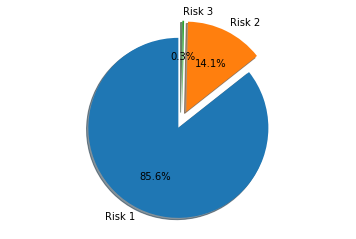

In [77]:
#Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Risk 1', 'Risk 2', 'Risk 3'
sizes = food_inspect_data_restaurant.risk.value_counts()
explode = (0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [78]:
food_inspect_data_restaurant.results.value_counts()

Pass                  22513
Pass w/ Conditions     8433
Fail                   8398
Name: results, dtype: int64

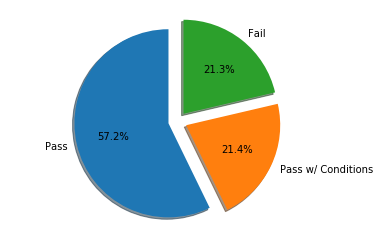

In [79]:
#Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Pass', 'Pass w/ Conditions', 'Fail'
sizes = food_inspect_data_restaurant.results.value_counts()
explode = (0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

/Users/aseel/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning:

The `size` parameter has been renamed to `height`; pleaes update your code.



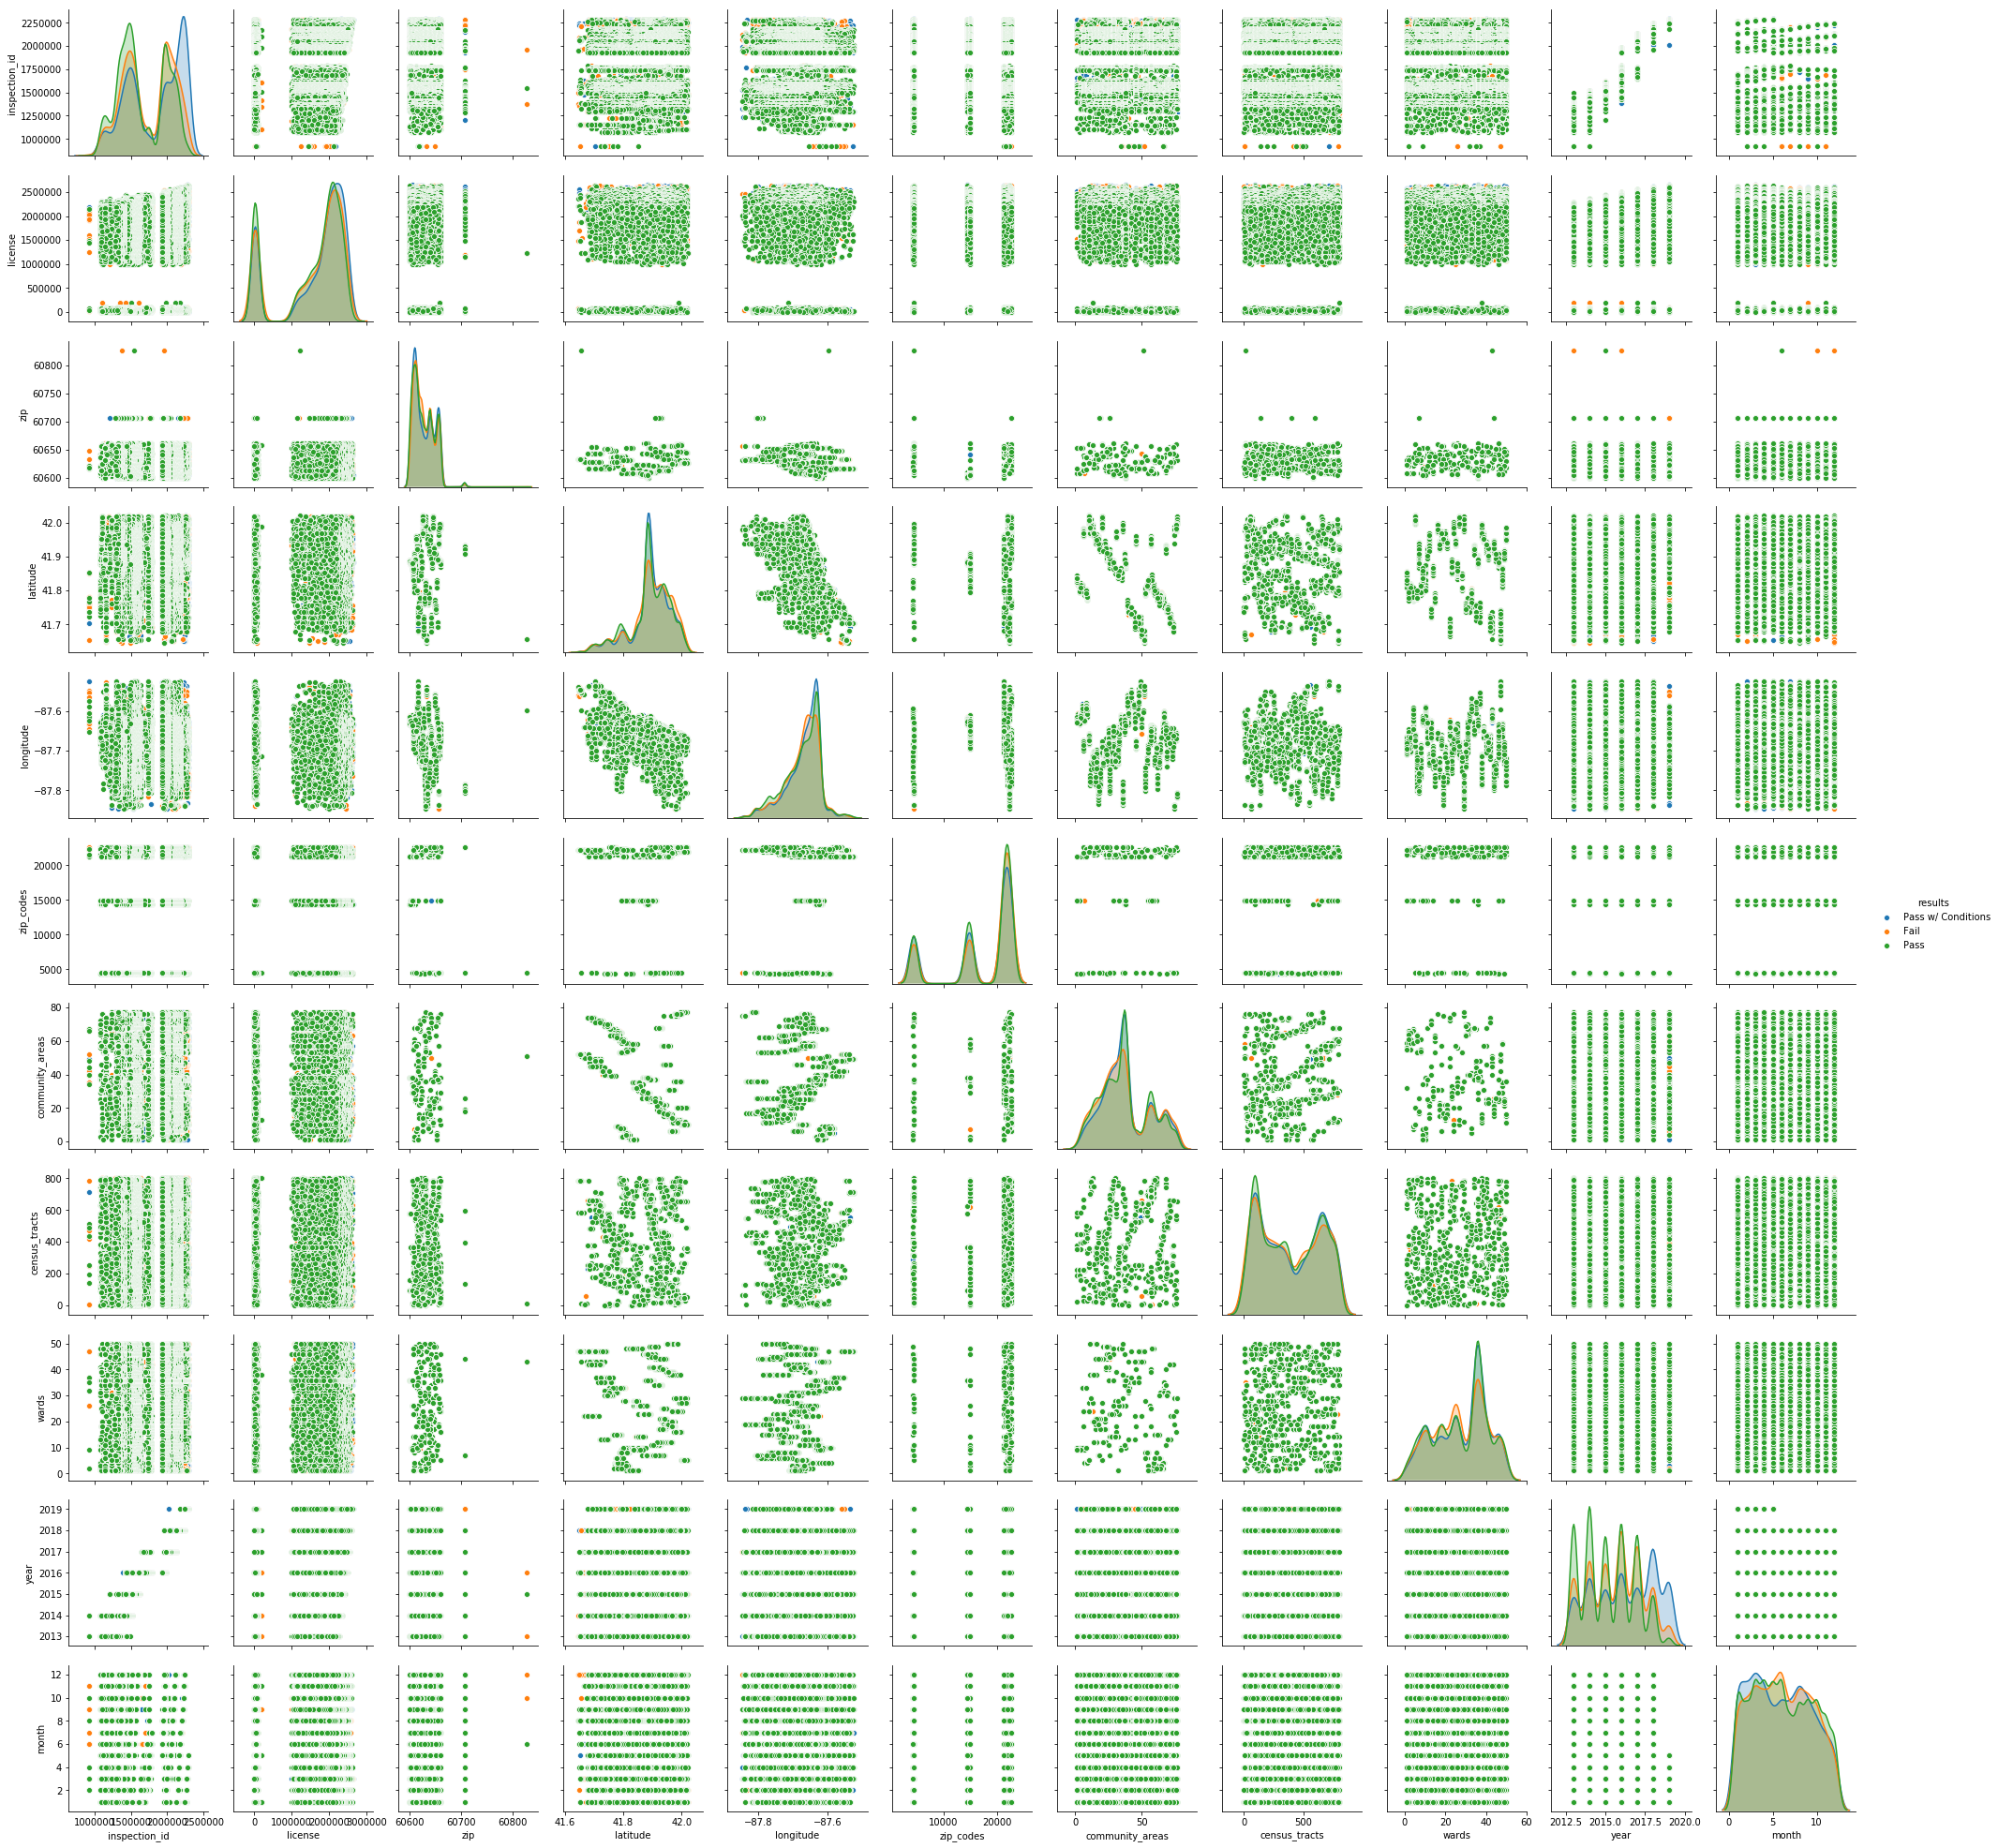

In [80]:
sns.pairplot(food_inspect_data_restaurant, hue='results', size=2.5);

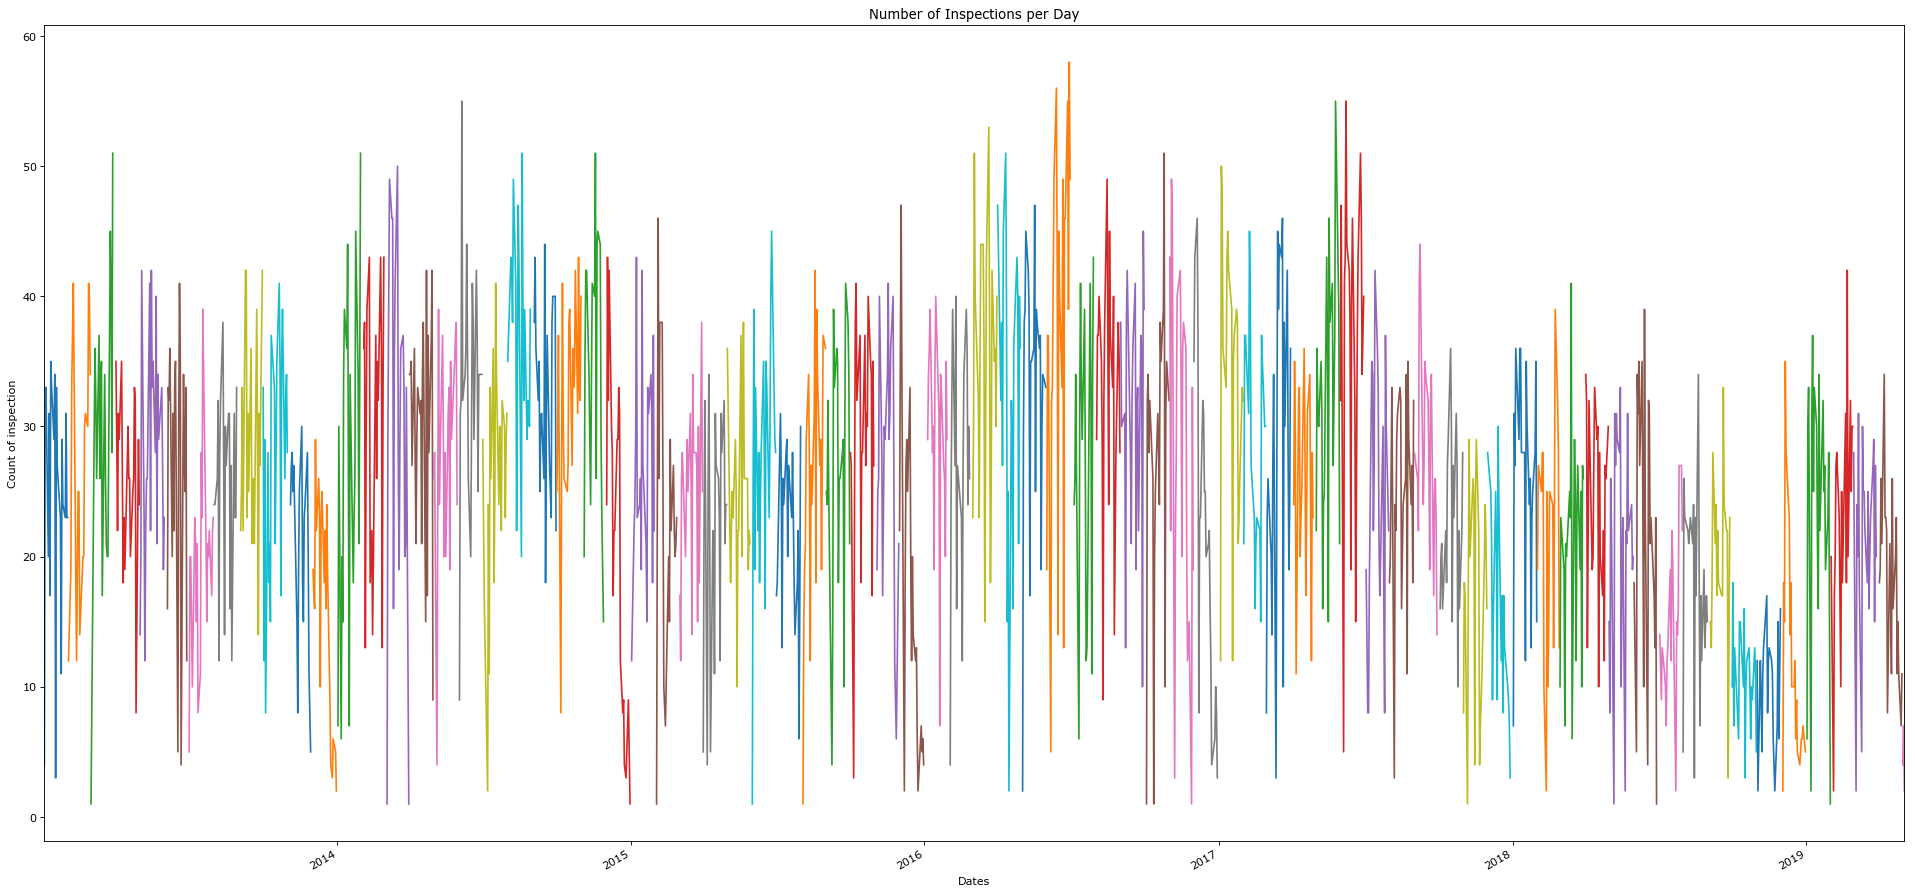

In [172]:
# lets try to see inspection count over time series
figure(num=None, figsize=(30, 15), dpi=80, facecolor='w', edgecolor='k')
food_inspect_data_restaurant['inspection_date'].value_counts().resample('M').plot.line()
plt.xlabel('Dates')
plt.ylabel('Count of inspection')
plt.title('Number of Inspections per Day')
plt.show();

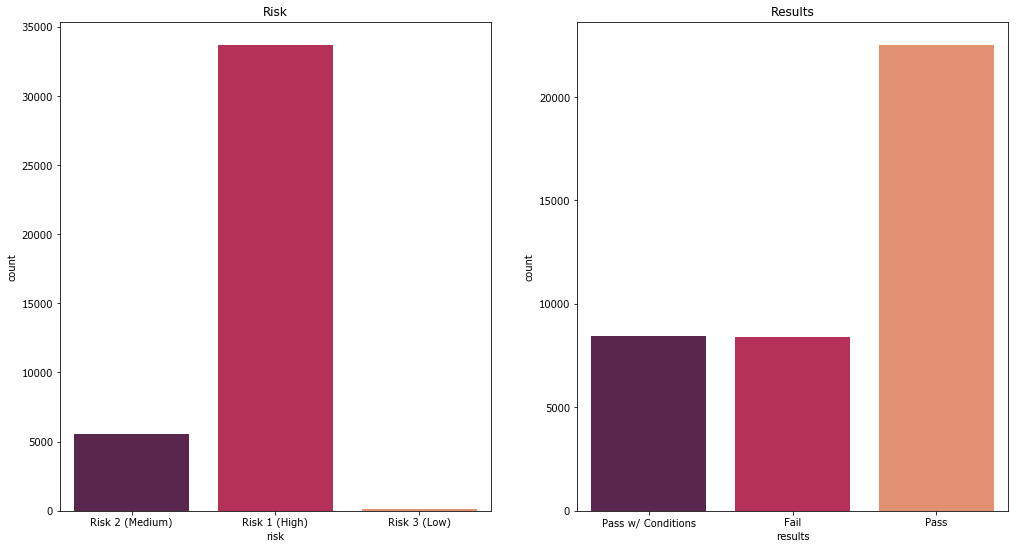

In [174]:
plt.figure(figsize=[17,9])
plt.subplot(1,2,1)
sns.countplot('risk', data=food_inspect_data_restaurant,palette="rocket");plt.title('Risk');
plt.subplot(1,2,2)
sns.countplot('results', data=food_inspect_data_restaurant,palette="rocket");
plt.title('Results');

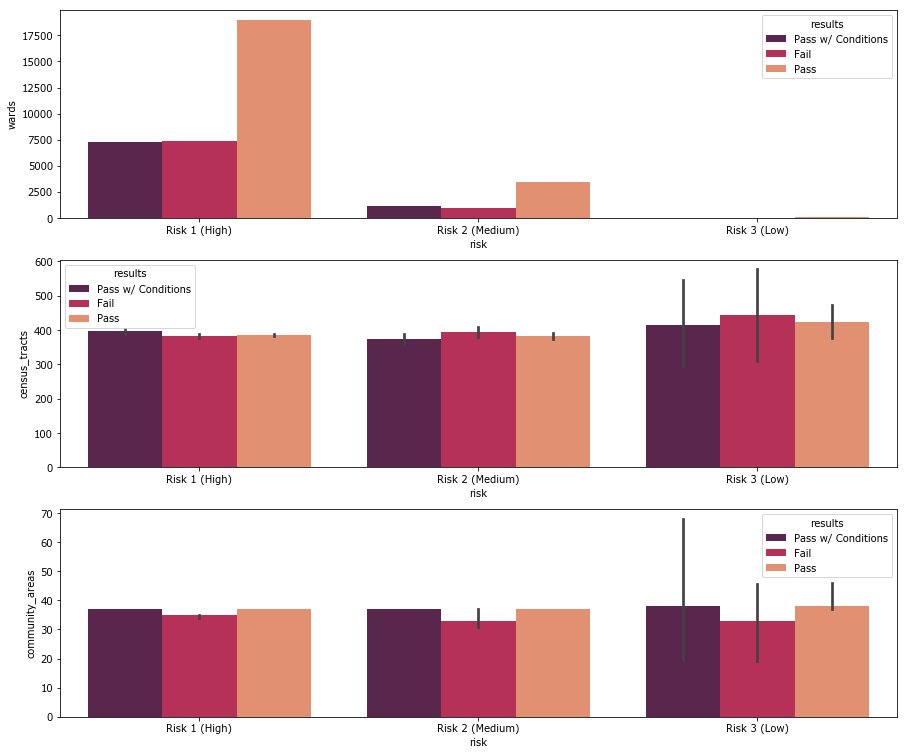

In [177]:

order=["Risk 1 (High)", "Risk 2 (Medium)", "Risk 3 (Low)"] # defining the order
fig, axs = plt.subplots(3, 1, figsize=(15, 13)) # to intiate the chart 3 rows by 1
sns.barplot(x='risk', y='wards', data=food_inspect_data_restaurant , ax=axs[0],hue='results',estimator=count_nonzero, order=order, palette="rocket") # count
sns.barplot(x='risk', y='census_tracts', data=food_inspect_data_restaurant, ax=axs[1] ,hue='results', estimator=mean, order=order,palette="rocket") # mean
sns.barplot(x='risk', y='community_areas', data=food_inspect_data_restaurant, ax=axs[2] ,hue='results', estimator=median, order=order,palette="rocket") # median

plt.show()

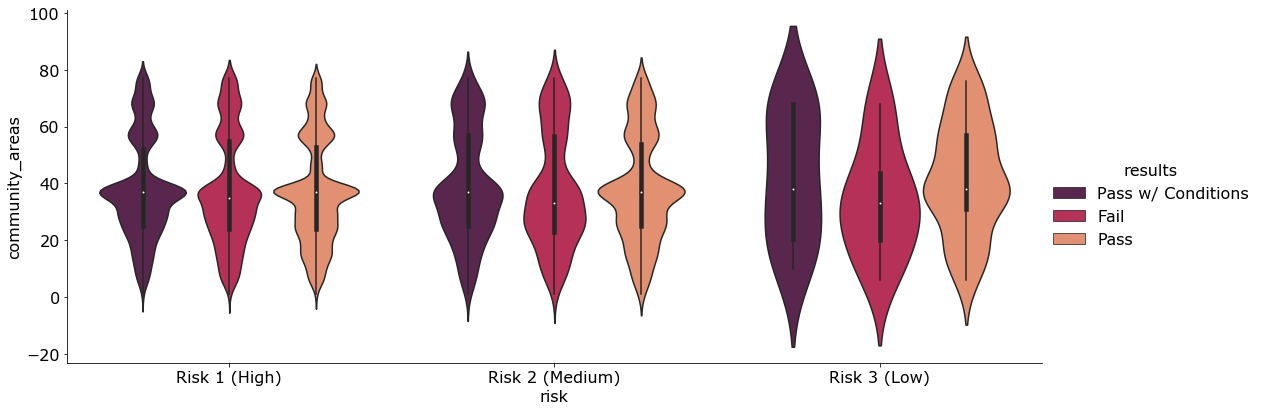

In [113]:
# distribution 

sns.catplot(x='risk', y='community_areas', data=food_inspect_data_restaurant ,kind="violin",hue='results'  ,order=order, height=6,aspect=2.5,palette="rocket" ) # count
plt.show()

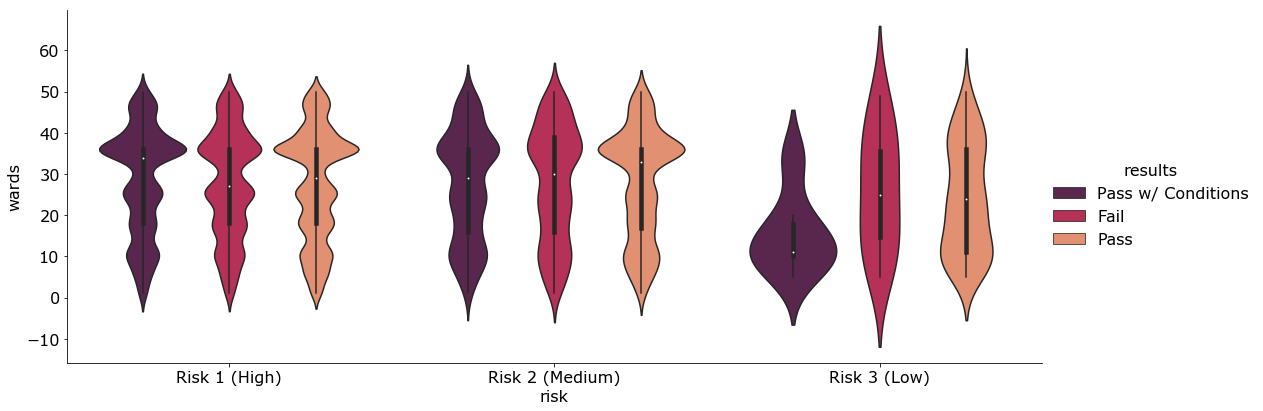

In [115]:
# distribution 

sns.catplot(x='risk', y='wards', data=food_inspect_data_restaurant ,kind="violin",hue='results'  ,order=order, height=6,aspect=2.5,palette="rocket") # count
plt.show()


In [222]:
# sns.set(style="whitegrid", palette="muted")

# # Draw a categorical scatterplot to show each observation
# sns.swarmplot(x="results", y="wards", hue="risk",
#               palette="rocket", data=food_inspect_data_restaurant)

In [86]:
# sns.set(style="white") 
# sns.relplot(x="year", y="inspection_id", hue="violations", size="weight",
#             sizes=(40, 400), alpha=.5, palette="muted",
#             height=6, data=mpg)

In [87]:
# sns.set(style="darkgrid")
# g = sns.jointplot("year", "zip_codes", data=food_inspect_data_restaurant, kind="reg",
#                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)

In [88]:
# ! conda install geopandas

In [87]:
# from shapely.geometry import Point
# import geopandas as gpd
# from geopandas import GeoDataFrame
# geometry = food_inspect_data_restaurant
# geometry = [Point(xy) for xy in zip(food_inspect_data_restaurant['longitude'], food_inspect_data_restaurant['latitude'])]
# gdf = GeoDataFrame(food_inspect_data_restaurant, geometry=geometry)   

# #this is a simple map that goes with geopandas
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [187]:
# # Use the 'hue' argument to provide a factor variable
# sns.lmplot( x="longitude", y="latitude", data=food_inspect_data_restaurant, fit_reg=False, hue='results', legend=False)
 
# # Move the legend to an empty part of the plot
# plt.legend(loc='lower right')
 
# plt.show

In [188]:
# import geoplot.crs as gcrs
# gcrs.choropleth(food_inspect_data_restaurant, hue='zip_codes', cmap='Greens', figsize=(8, 4))

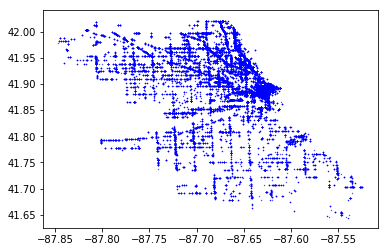

In [90]:

# Plot the service district shapefile
# service_district.plot(figsize=(10,10))

# Add the chicken locations
plt.scatter(x = food_inspect_data_restaurant.longitude, y = food_inspect_data_restaurant.latitude, c = 'blue',s=0.1)

# Show the plot
plt.show()

In [189]:
# # import colorlover as cl
# # import numpy as np
# # import plotly.plotly as py
# # import plotly.graph_objs as go

# # data = []
# # counter = 0
# # for col in food_inspect_data_restaurant.columns:
# #     if col != 'r':
# #         food_inspect_data_restaurant.append(
# #             go.Area(t=df['r'],
# #                     r=df[col],
# #                     marker=dict(color=cl.scales['9']['seq']['PuBu'][counter]),
# #                     name=col+' m/s' ) )
# #         counter+=1

# fig = Figure(data=food_inspect_data_restaurant.zip, layout=go.Layout(orientation=270, barmode='stack'))

# # IPython notebook
# # py.iplot(fig, filename='pandas-wind-rose-chart')

# url = py.plot(fig, filename='pandas-wind-rose-chart')

In [93]:
# #!/usr/bin/python
# from mpl_toolkits.basemap import Basemap
# import matplotlib
# import matplotlib.pyplot as plt
# import numpy as np
# import csv

# # setting parameters for title and axes
# font = {'family' : 'verdana',
#         'size'   : 16}
# matplotlib.rc('font', **font)

# # # Grabbing the .csv data
# # lats,lons,names,altitude = [],[],[],[]
# # temp_dat = []
# # with open('asos_stations.csv') as csvfile:
# #     reader = csv.DictReader(csvfile,delimiter=',')
# #     for data in reader:
# #         if float(data['UTC'])>-5. or float(data['UTC'])<-8. or float(data['ELEV'])<0.0:
# #             continue
# #         names.append('K'+data['CALL'])
# #         lats.append(float(data['LAT']))
# #         lons.append(float(data['LON']))
# #         altitude.append(float(data['ELEV']))
        
# # How much to zoom from coordinates (in degrees)
# zoom_scale = 3

# # Setup the bounding box for the zoom and bounds of the map
# bbox = [np.min(food_inspect_data_restaurant.latitude)-zoom_scale,np.max(food_inspect_data_restaurant.latitude)+zoom_scale,\
#         np.min(food_inspect_data_restaurant.longitude)-zoom_scale,np.max(food_inspect_data_restaurant.longitude)+zoom_scale]

# fig, ax = plt.subplots(figsize=(12,7))
# plt.title("ASOS Continental United States (CONUS) Station Elevation")
# # Define the projection, scale, the corners of the map, and the resolution.
# m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
#             llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

# # Draw coastlines and fill continents and water with color
# m.drawcoastlines()
# m.fillcontinents(color='#CCCCCC',lake_color='lightblue')

# # draw parallels, meridians, and color boundaries
# m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
# m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=15)
# m.drawmapboundary(fill_color='lightblue')

# # format colors for elevation range
# alt_min = np.min(food_inspect_data_restaurant.results)
# alt_max = np.max(food_inspect_data_restaurant.results)
# cmap = plt.get_cmap('gist_earth')
# normalize = matplotlib.colors.Normalize(vmin=alt_min, vmax=alt_max)

# # plot elevations with different colors using the numpy interpolation mapping tool
# # the range [50,200] can be changed to create different colors and ranges
# for ii in range(0,len(food_inspect_data_restaurant.location)):
#     x,y = m(lons[ii],lats[ii])
#     color_interp = np.interp(altitude[ii],[alt_min,alt_max],[50,200])
#     plt.plot(x,y,3,marker='o',color=cmap(int(color_interp)))

# # format the colorbar 
# cax, _ = matplotlib.colorbar.make_axes(ax)
# cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,norm=normalize,label='Elevation')

# # save the figure and show it
# # plt.savefig('asos_station_elevation.png', format='png', dpi=500,transparent=True)
# plt.show()

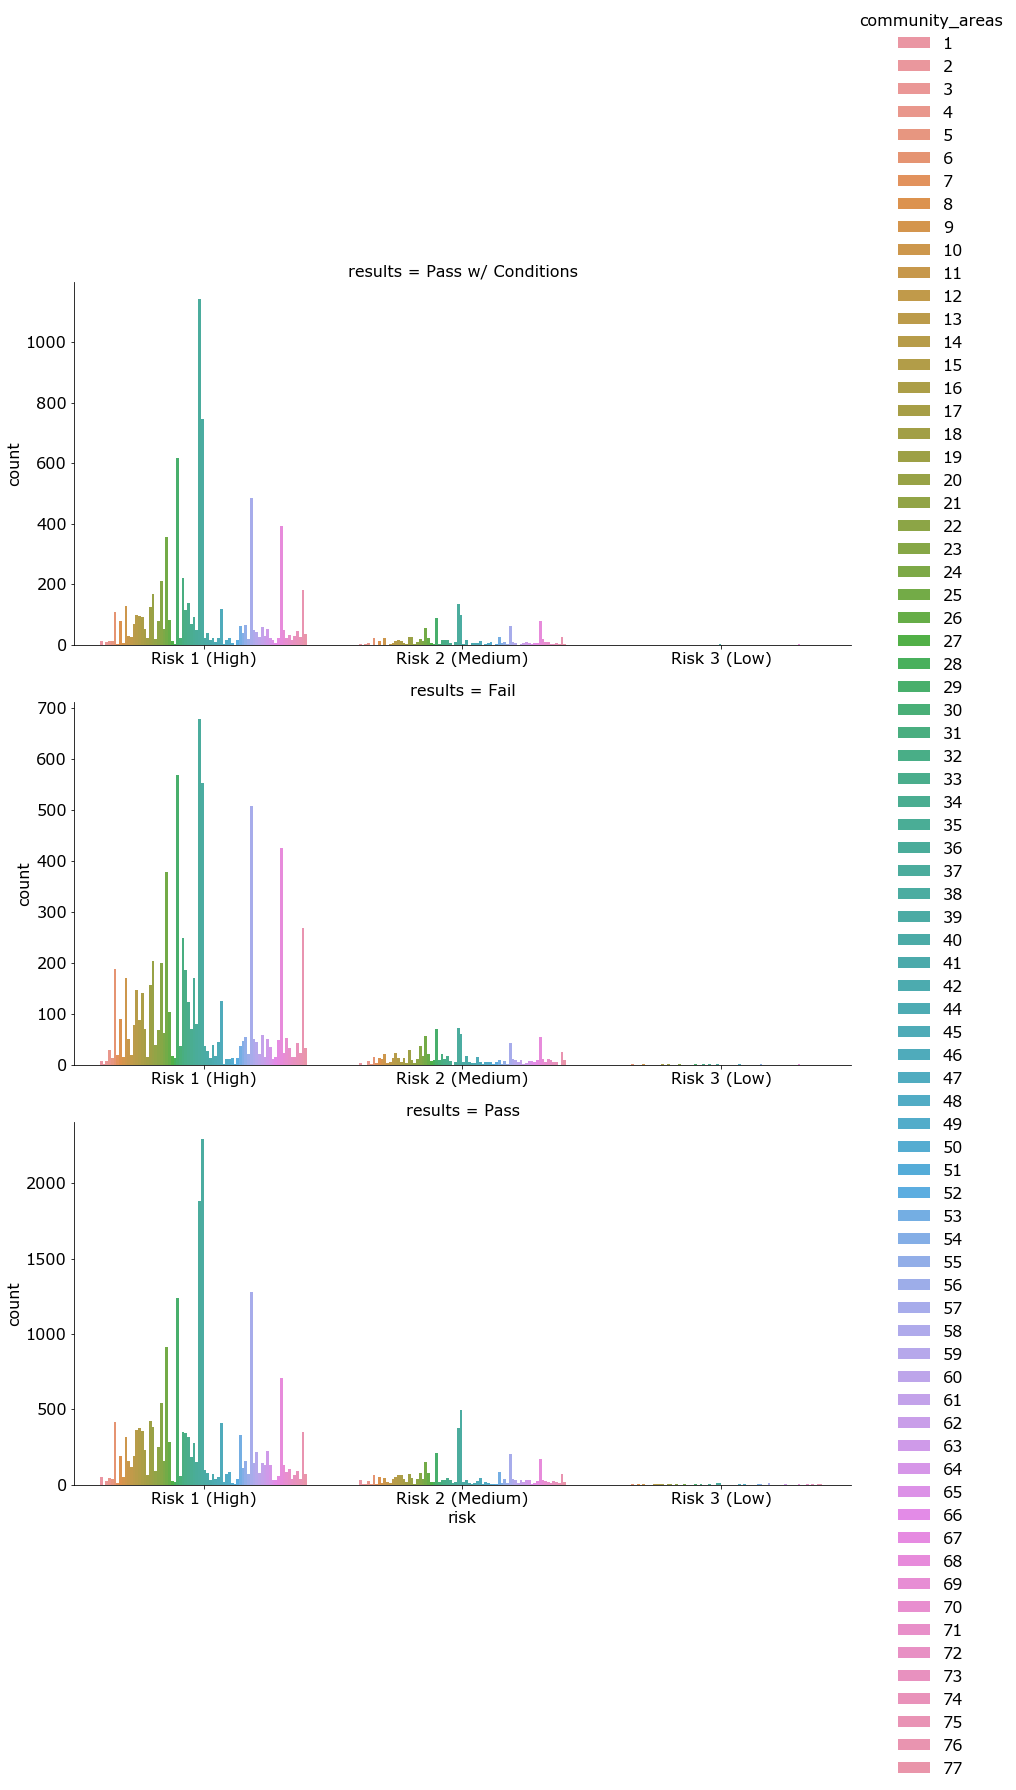

In [94]:
# wards based on inspection results 
sns.catplot(x='risk',col='results', data=food_inspect_data_restaurant ,kind="count",hue='community_areas',col_wrap=1, order=order,sharey=False,sharex=False,height=6,aspect=2)#, height=6,aspect=2.5) # count
plt.show()

In [93]:
food_inspect_data_restaurant.groupby(['license','year'])['inspection_id'].count()

license  year
2        2013    1
         2014    2
         2015    1
         2016    2
         2017    1
         2018    1
9        2013    2
         2014    1
         2015    2
         2016    2
         2017    1
         2018    1
40       2014    1
         2015    1
         2016    1
         2017    1
         2018    1
62       2013    2
         2014    2
         2015    1
         2016    2
         2017    1
         2018    1
99       2013    2
         2014    1
         2015    1
         2016    1
115      2013    1
         2014    1
         2015    1
                ..
2617051  2019    1
2617275  2019    1
2617404  2018    1
2617422  2019    1
2621281  2019    1
2621507  2019    1
2621517  2019    1
2621644  2019    1
2621839  2019    1
2621858  2019    1
2621874  2019    1
2622264  2019    1
2622688  2019    1
2622793  2019    1
2626424  2019    1
2626654  2019    1
2626697  2019    1
2627220  2019    1
2630672  2019    1
2631745  2019    1
2631850  2019    

In [94]:
# food_inspect_data_restaurant.census_tracts

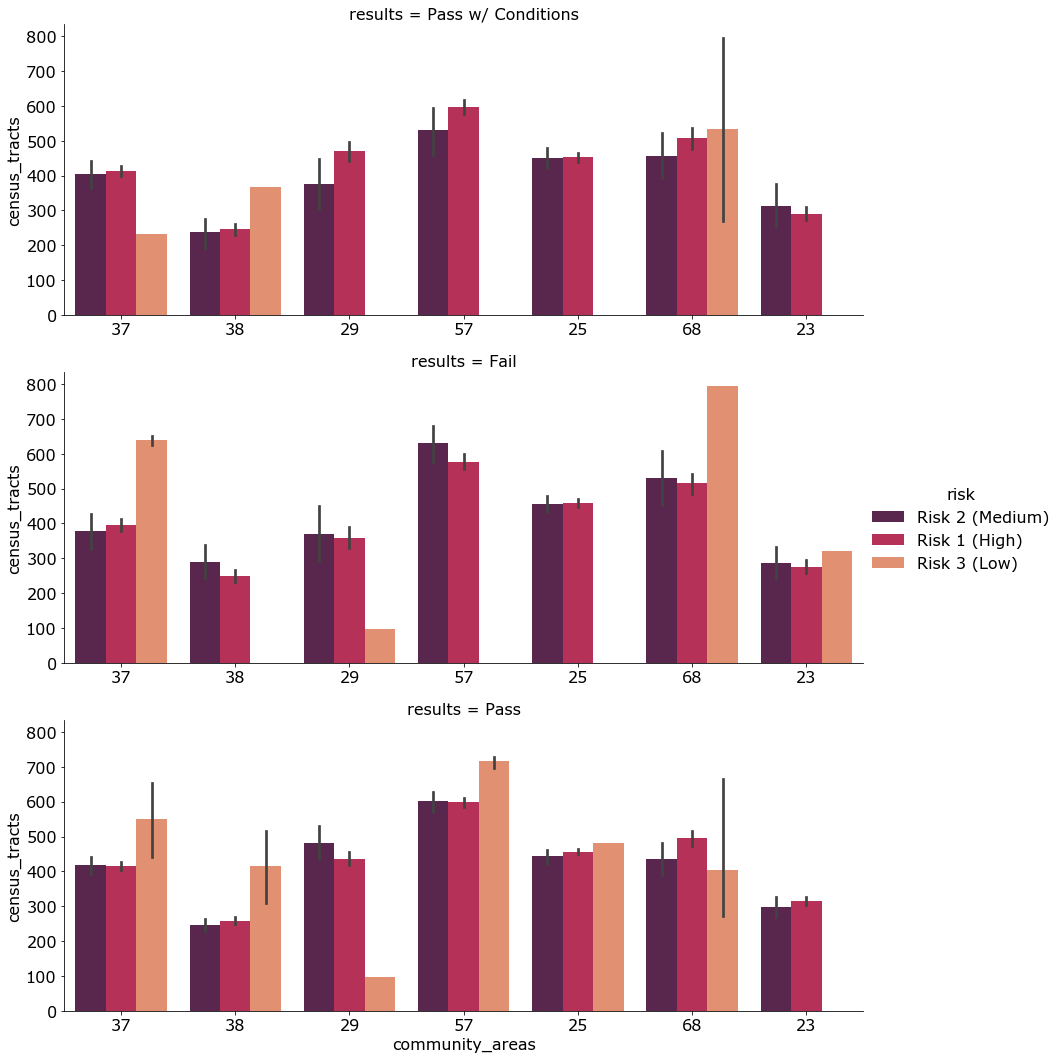

In [95]:
# does inspection type affect pass or fail results?
sns.catplot(x='community_areas', y='census_tracts', data=food_inspect_data_restaurant,hue='risk',row='results'
            ,kind='bar',estimator=mean, order=food_inspect_data_restaurant['community_areas'].value_counts().iloc[:7].index
            ,height=5, aspect=2.5, sharex=False, legend_out=True,palette="rocket") # mean

plt.show()

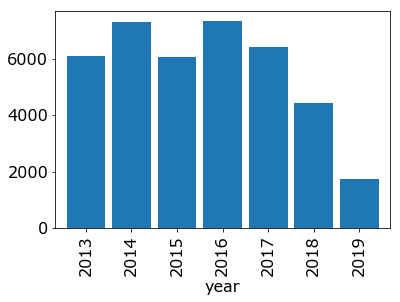

In [96]:
food_inspect_data_restaurant.groupby(['year'])['license'].count().plot(kind='bar',width=0.85);

In [206]:
# import plotly
# import plotly.plotly as py
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go

In [100]:
# food_inspect_data_restaurant_color = food_inspect_data_restaurant
# risk_color_map = { "All": "rgb(0, 0, 0)", "Risk 1 (High)": "rgb(255, 0, 0)", "Risk 2 (Medium)": "rgb(204, 204, 0)", "Risk 3 (Low)": "rgb(0, 100, 0)" }
# food_inspect_data_restaurant_color['risk_color'] = food_inspect_data_restaurant['risk'].map(risk_color_map)

In [112]:
# data = [
#     go.Scattermapbox(
#         lat = food_inspect_data_restaurant['latitude'],
#         lon = food_inspect_data_restaurant['longitude'],
#         text = food_inspect_data_restaurant['dba_name'],
#         hoverinfo = 'text',
#         mode = 'markers',
#         marker = go.scattermapbox.Marker(
#             color = food_inspect_data_restaurant_color['risk_color'],
#             opacity = 0.7,
#             size = 4
#         )
#     )
# ]

# layout = go.Layout(
#     mapbox = dict(
#         accesstoken = 'pk.eyJ1IjoiYXNlZWxhbGF3YWRoIiwiYSI6ImNqdnA3NmpoMTFieWY0OGxlYXJydDJzdnQifQ.LXV6UKvP50XyfhTnnCEftw',
#         zoom = 10,
#         center = dict(
#             lat = 41.8781,
#             lon = -87.6298
#         ),
#     ),
#     height = 800,
#     width = 800,
#     title = "Facilities in Chicago")

# fig = go.Figure(data, layout)
# iplot(fig, filename = 'facilities')

In [190]:
# plt.bar( food_inspect_data_restaurant.groupby(food_inspect_data_restaurant['inspection_date','results']).count(['year']).reset_index(month)

In [147]:
# investigate multiple variables at the same time
# sns.boxplot(data=food_inspect_data_restaurant.drop(['inspection_date'], axis=1));

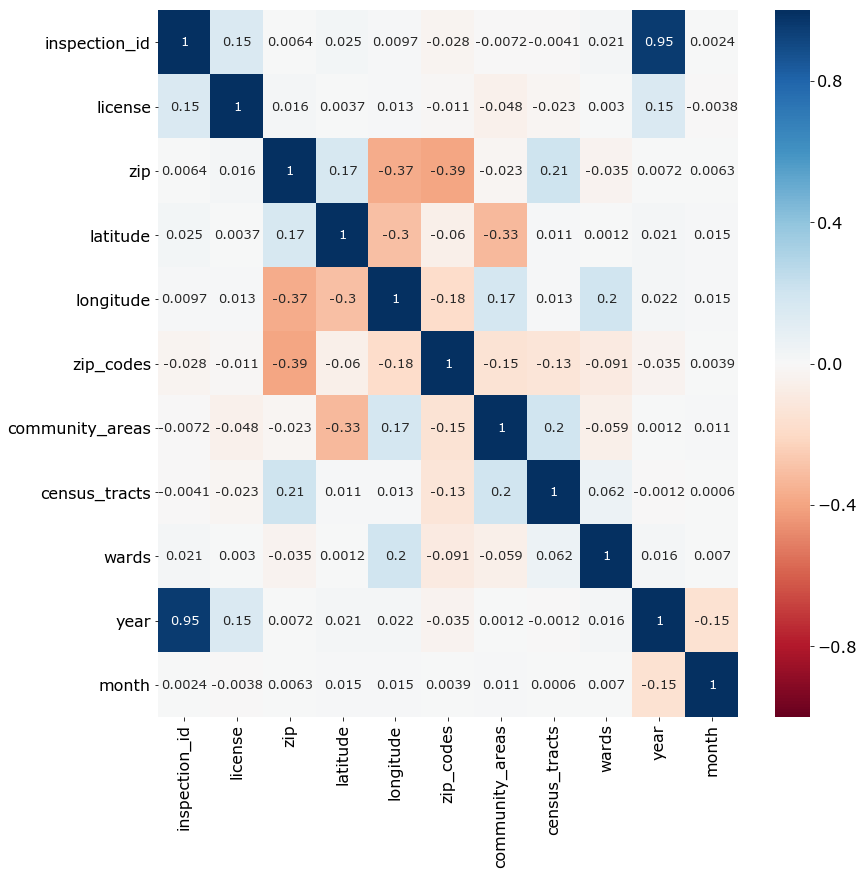

In [151]:
# note: setting vmin and vmax help balance out the color satuation for comparison
plt.figure(figsize=(13, 13))

sns.heatmap(food_inspect_data_restaurant.corr(), annot=True, cmap="RdBu", center=0, vmin=-1, annot_kws={'size':13});
    # sns.heatmap(boston.corr(), annot=True, mask=boston.corr() < 0); # masksing values (hide them)

In [109]:
# food_inspect_data_restaurant.to_csv('Data/Food Inspections for Restaurant.csv')

In [103]:
# food_inspect_data_restaurant['wards'].plot(color = 'b', style='.-',legend=True)
# food_inspect_data_restaurant['license'].plot(color = 'r', style='.',legend=True);

In [105]:
# food_inspect_data_restaurant.plot(x='license', y='inspection_date');

In [106]:
# food_inspect_data_restaurant.plot(x='community_areas', y='inspection_id', kind='scatter')


In [107]:
# food_inspect_data_restaurant.plot(x='license', y='wards', kind='scatter');

In [108]:
# food_inspect_data_restaurant.plot(kind= 'hist', bins=50, range=(0,8), alpha=0.3);

In [109]:
# daily_mean = food_inspect_data_restaurant.inspection_date.resample('D').mean()

In [110]:
# food_inspect_data_restaurant['inspection_date'].plot(style='k.-');

In [111]:
# food_inspect_data_restaurant.loc['2016', ['license','violations']].plot(subplots=True)

In [186]:

# plt.figure(figsize=[11,7])
# # plt.xticks(np.arange(0, 3500, step=500)) # better presentation for xticks
# # plt.yticks([]) # removes yticks
# plt.ylabel('frequency')
# sns.distplot(food_inspect_data_restaurant.license, fit=norm, color= 'green', bins=35)
# plt.rcParams['font.size'] = 13;


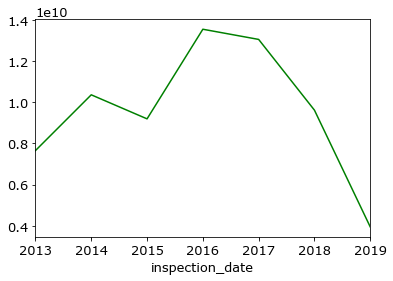

In [211]:
food_inspect_data_restaurant.groupby('inspection_date').sum().resample('A')['inspection_id'].sum().plot(c='Green');

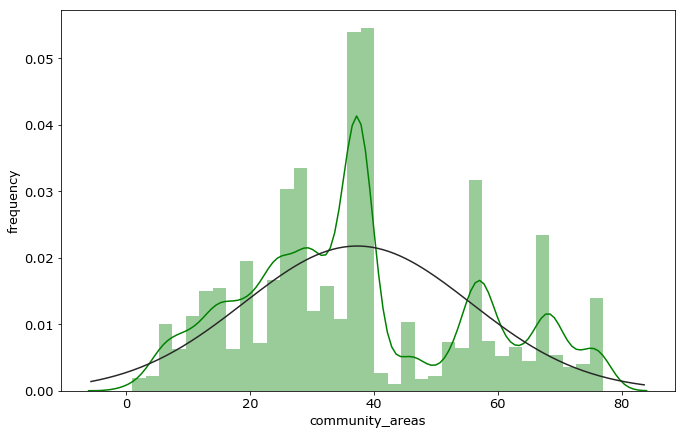

In [180]:
plt.figure(figsize=[11,7])
plt.ylabel('frequency')
sns.distplot(food_inspect_data_restaurant['community_areas'], fit=norm, color= 'green', bins=35)
plt.rcParams['font.size'] = 13;



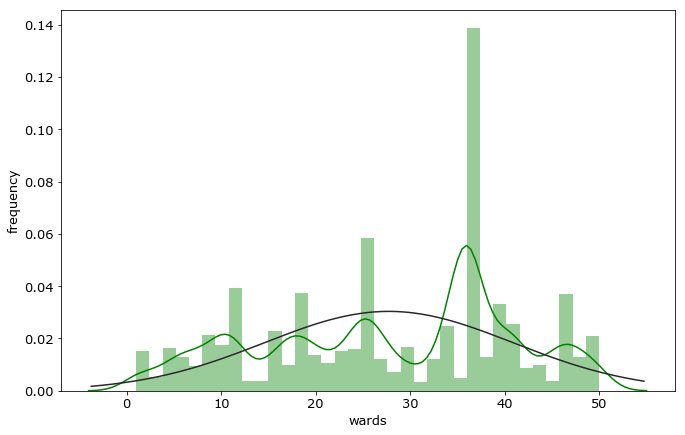

In [192]:
plt.figure(figsize=[11,7])
plt.ylabel('frequency')
sns.distplot(food_inspect_data_restaurant['wards'], fit=norm, color= 'green', bins=35)
plt.rcParams['font.size'] = 13;

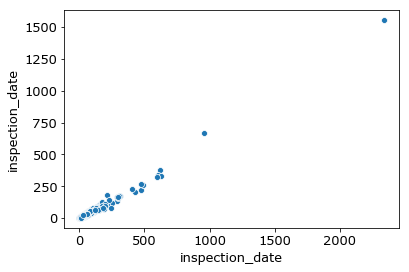

In [185]:
X = food_inspect_data_restaurant.groupby('census_tracts')['inspection_date'].count()
y = food_inspect_data_restaurant[food_inspect_data_restaurant.results == "Pass"].groupby('census_tracts')['inspection_date'].count()
sns.scatterplot(x = X,y= y);

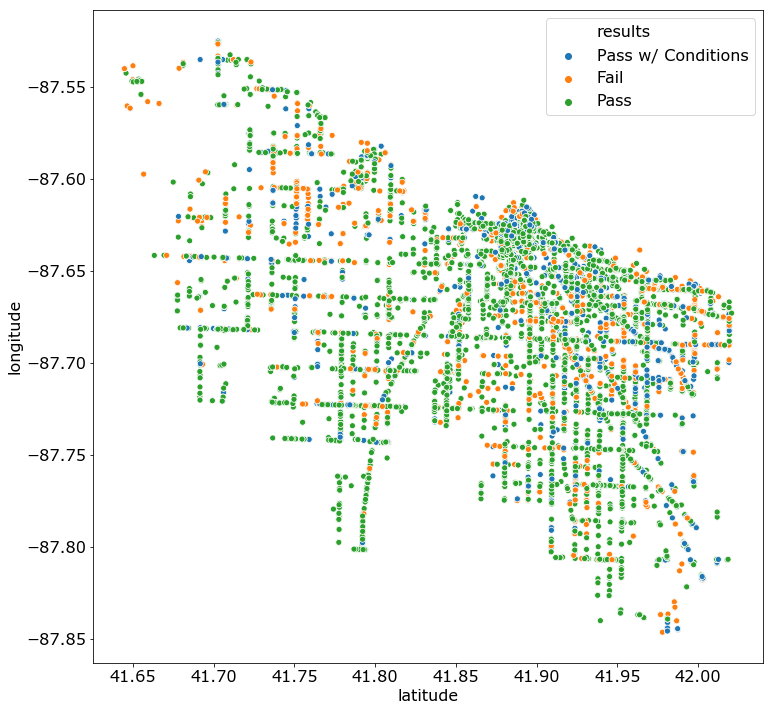

In [107]:
plt.figure(figsize=(12,12))
sns.scatterplot(x="latitude", y="longitude", data=food_inspect_data_restaurant, hue="results");

In [ ]:
# def scatter_box(x):
#     plt.figure(figsize=(10,8))
#     if str(x.dtype) != 'object':
#         sns.regplot(x, food_inspect_data_restaurant.license)
#     else:
#         sns.boxplot(x, food_inspect_data_restaurant.license)
#         plt.show()
#         print(x.value_counts())

In [104]:
# # Save results
# values.to_csv(('Data/violation_values.csv'), index=False)
# counts.to_csv(('Data/violation_counts.csv'), index=False)
# titles.to_csv(('Data/violation_titles.csv'), index=False)

### Save the data set 

In [105]:
food_inspect_data_restaurant.to_csv('Data/Food Inspections for Restaurant.csv')

In [106]:
food_inspect_data_restaurant.shape

(39344, 19)

In [200]:
food_inspect_data_restaurant.groupby('community_areas')['inspection_date'].count()

community_areas
1      107
2        3
3       51
4      120
5       75
6      818
7       39
8      436
9       98
10     708
11     253
12     185
13     393
14     698
15     648
16     678
17     415
18     122
19     841
20     832
21     164
22     450
23    1083
24     345
25    1913
26     594
27      83
28      61
29    2795
30     144
      ... 
48     127
49     144
50      52
51       6
52      74
53     548
54     222
55     325
56     127
57    2584
58     297
59     348
60     140
61     304
62     198
63     368
64     234
65      77
66      70
67     170
68    1835
69     270
70     192
71     210
72      92
73     141
74     204
75     102
76     924
77     164
Name: inspection_date, Length: 76, dtype: int64

In [202]:
food_inspect_data_restaurant.groupby('wards')['inspection_date'].count()

wards
1      596
2      235
3      283
4      208
5      694
6      713
7      525
8      657
9      517
10     966
11    1587
12     584
13     214
14     196
15     333
16     931
17     549
18    1542
19     526
20     756
21     590
22     202
23     628
24     888
25    1727
26    1486
27     667
28     389
29     494
30     437
31     193
32     233
33     444
34    1371
35     280
36    7491
37     142
38     706
39     770
40    1068
41    1402
42     476
43     147
44     398
45     197
46    1653
47     387
48     706
49     457
50     703
Name: inspection_date, dtype: int64

In [147]:
# Sort inspections by date
df = food_inspect_data_eng.sort_values(by="inspection_date")

# Only consider inspections with clear results
df = df.loc[df.results.isin(["Pass", "Fail"])]

# Group inspections by license and shift 1 to find previous results
df["previous_results"] = df.groupby(by="license").shift().results

# Calculate cross tabulation of results and previous results
chart = pd.crosstab(df.previous_results, df.results)

# Make Numpy array of total counts of prior fails and passes with the 
# following(post) results
chart_arr = np.array(chart)

# Create new dataframe from Numpy array to clearly dispay prior and 
# post results
pass_fail_chart = pd.DataFrame({"Prior Fail":chart_arr[:,0],
                                "Prior Pass":chart_arr[:,1]})
pass_fail_chart.index = pass_fail_chart.index.rename("")
pass_fail_chart = pass_fail_chart.rename(index={0:"Post Fail",1:"Post Pass"})

# Display chart
pass_fail_chart

,Prior Fail,Prior Pass
,,
Post Fail,1992,3051
Post Pass,3904,12254


In [205]:
food_inspect_data_restaurant.groupby(['license','year'])['inspection_id'].count()

license  year
2        2013    1
         2014    2
         2015    1
         2016    2
         2017    1
         2018    1
9        2013    2
         2014    1
         2015    2
         2016    2
         2017    1
         2018    1
40       2014    1
         2015    1
         2016    1
         2017    1
         2018    1
62       2013    2
         2014    2
         2015    1
         2016    2
         2017    1
         2018    1
99       2013    2
         2014    1
         2015    1
         2016    1
115      2013    1
         2014    1
         2015    1
                ..
2617051  2019    1
2617275  2019    1
2617404  2018    1
2617422  2019    1
2621281  2019    1
2621507  2019    1
2621517  2019    1
2621644  2019    1
2621839  2019    1
2621858  2019    1
2621874  2019    1
2622264  2019    1
2622688  2019    1
2622793  2019    1
2626424  2019    1
2626654  2019    1
2626697  2019    1
2627220  2019    1
2630672  2019    1
2631745  2019    1
2631850  2019    

# 4.0 Data Engineer

In [122]:
# Read in datasets from csv to pandas dataframes,
#load only useful columns
food_inspection = pd.read_csv('Data/Food Inspections for Restaurant.csv')
food_inspection = food_inspection.drop(['Unnamed: 0'], axis=1)

In [123]:
food_inspection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39344 entries, 0 to 39343
Data columns (total 19 columns):
inspection_id      39344 non-null int64
dba_name           39344 non-null object
license            39344 non-null int64
risk               39344 non-null object
address            39344 non-null object
zip                39344 non-null int64
inspection_date    39344 non-null object
results            39344 non-null object
violations         39344 non-null object
latitude           39344 non-null float64
longitude          39344 non-null float64
zip_codes          39344 non-null int64
community_areas    39344 non-null int64
census_tracts      39344 non-null int64
wards              39344 non-null int64
year               39344 non-null int64
month              39344 non-null int64
day_of_week        39344 non-null object
risk_color         39344 non-null object
dtypes: float64(2), int64(9), object(8)
memory usage: 5.7+ MB


### 4.1 Calculating Violations Data to add it on our data

In [5]:
# food_inspect_data_restaurant.iloc[0].violations[:10000]

In [735]:
# https://webapps1.cityofchicago.org/healthinspection/Code_Violations.jsp

In [736]:
# # Generate column names
# critical_columns = [("v_" + str(num)) for num in range(1, 15)]
# serious_columns = [("v_" + str(num)) for num in range(15, 30)]
# minor_columns = [("v_" + str(num)) for num in range(30, 45)]
# minor_columns.append("v_70")

# columns = critical_columns + serious_columns + minor_columns

In [737]:
# # Split violations into binary values for each violation
# def split_violations(violations):
#     values_row = pd.Series([])
    
#     if type(violations) == str:
#         violations = violations.split(' | ')
#         for violation in violations:
#             index = "v_" + violation.split('.')[0]
#             values_row[index] = 1
#     return values_row

In [738]:
# # 5 mins
# values_data = food_inspect_data_restaurant.violations.apply(split_violations)

In [739]:
# # Ensure no missing columns, fill NaN
# values = pd.DataFrame(values_data, columns=columns).fillna(0)

# values['inspection_id'] = food_inspect_data_restaurant.inspection_id

In [740]:
# # Count violations
# counts = pd.DataFrame({
#     "critical_count": values[critical_columns].sum(axis=1),
#     "serious_count": values[serious_columns].sum(axis=1),
#     "minor_count": values[minor_columns].sum(axis=1)
# })

# counts['inspection_id'] = food_inspect_data_restaurant.inspection_id

In [741]:
# food_inspect_data_restaurant.violations.value_counts()

In [742]:
# titles = pd.DataFrame({
#     "v_1": "Approved food sources (1)",
#     "v_2": "Hot/cold storage facilities (2)",
#     "v_3": "Hot/cold storage temp. (3)",
#     "v_4": "Contaminant protection (4)",
#     "v_5": "No sick handlers (5)",
#     "v_6": "Proper hand washing (6)",
#     "v_7": "Proper utensil washing (7)",
#     "v_8": "Proper sanitizing solution (8)",
#     "v_9": "Hot/cold water supply (9)",
#     "v_10": "Waste water disposal (10)",
#     "v_11": "Adequate toilet facilities (11)",
#     "v_12": "Adequate hand washing facilities (12)",
#     "v_13": "Control of rodents, other pests (13)",
#     "v_14": "Correct serious violations (14)",
#     "v_15": "No re-served food (15)",
#     "v_16": "Protection from contamination (16)",
#     "v_17": "Proper thawing (17)",
#     "v_18": "Pest control, associated areas (18)",
#     "v_19": "Proper garbage area (19)",
#     "v_20": "Proper garbage storage (20)",
#     "v_21": "Oversight of hazardous food (21)",
#     "v_22": "Dishwasher maintenance (22)",
#     "v_23": "Scrape before washing (23)",
#     "v_24": "Proper dishwashers (24)",
#     "v_25": "Minimize toxic materials (25)",
#     "v_26": "Adequate customer toilets (26)",
#     "v_27": "Supplied toilet facilities (27)",
#     "v_28": "Visible inspection report (28)",
#     "v_29": "Correct minor violations (29)",
#     "v_30": "Labelled containers (30)",
#     "v_31": "Sterile utensils (31)",
#     "v_32": "Clean, maintain equipment (32)",
#     "v_33": "Clean, sanitize utensils (33)",
#     "v_34": "Clean, maintain floor (34)",
#     "v_35": "Maintain walls & ceiling (35)",
#     "v_36": "Proper lighting (36)",
#     "v_37": "Toilet rooms vented (37)",
#     "v_38": "Proper venting, plumbing (38)",
#     "v_39": "Linen, clothing storage (39)",
#     "v_40": "Proper thermometers (40)",
#     "v_41": "Clean facilities, store supplies (41)",
#     "v_42": "Ice handling, hairnets, clothes (42)",
#     "v_43": "Ice equipment storage (43)",
#     "v_44": "Restrict prep area traffic (44)",
#     "v_70": "Restrict smoking (70)"}, index=[0])

In [743]:
# # Display selection of values dataframe
# values.iloc[:170]

In [744]:
# values.shape

In [124]:
food_inspection.columns

Index(['inspection_id', 'dba_name', 'license', 'risk', 'address', 'zip',
       'inspection_date', 'results', 'violations', 'latitude', 'longitude',
       'zip_codes', 'community_areas', 'census_tracts', 'wards', 'year',
       'month', 'day_of_week', 'risk_color'],
      dtype='object')

In [125]:
count_violations = food_inspection['violations'].str.extractall('(\d+\.)')
count_violations = count_violations[~count_violations[0].astype(str).str.startswith('0')]
count_violations = count_violations.reset_index(level=1, drop=True)

# replace .
count_violations = count_violations[0]
count_violations = count_violations.str.replace(r'\.','')

# To remove duplicates within the list of violations
def remove_duplicates(values):
    output = []
    seen = set()
    for i in values:
        if i not in seen:
            output.append(i)
            seen.add(i)
    return output

violations_lst = []
ind = []
count = []
index = food_inspection.index
for i in range(len(index)):
    try:
       # Remove duplicates from this list.
        rm_duplicates = np.array(count_violations[index[i]])
        if len(rm_duplicates) > 1:
            violations = remove_duplicates(rm_duplicates)
            violations_lst.append(violations)
        ind.append(index[i])
        count.append(len(violations))
    except TypeError:
        violations_lst.append(count_violations[index[i]])
        ind.append(index[i])
        count.append(1)
        continue
    except:
        violations_lst.append(0)
        ind.append(index[i])
        count.append(0)
        continue

violations_df = pd.DataFrame({'violations':violations_lst})
violations_df = np.asarray(violations_df['violations'])
violations_df = pd.DataFrame({'violations':violations_df})
violations_df['index'] = ind
violations_df['no_of_violations'] = count

In [126]:
violations_df.head()

,violations,index,no_of_violations
0,"[3, 5, 36]",0,3
1,"[3, 5, 58]",1,3
2,"[3, 5, 23, 1, 47, 55, 58]",2,7
3,"[3, 5, 10, 23, 37, 38, 48, 55]",3,8
4,48,4,1


In [127]:
food_inspection = pd.concat([food_inspection, violations_df], axis=1)

In [128]:
food_inspection.head()

,inspection_id,dba_name,license,risk,address,zip,inspection_date,results,violations,latitude,...,community_areas,census_tracts,wards,year,month,day_of_week,risk_color,violations,index,no_of_violations
0,2288221,paleteria ayutla,2321232,Risk 2 (Medium),2404 W 46TH PL,60632,2019-05-03,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.809457,...,55,687,3,2019,5,Friday,"rgb(204, 204, 0)","[3, 5, 36]",0,3
1,2288211,subway,1495274,Risk 1 (High),3167 N LINCOLN AVE,60657,2019-05-03,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939425,...,57,712,40,2019,5,Friday,"rgb(255, 0, 0)","[3, 5, 58]",1,3
2,2286189,lindo guadalajara restaurant,2196302,Risk 1 (High),4761 N CLARK ST,60640,2019-05-02,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968819,...,31,611,39,2019,5,Thursday,"rgb(255, 0, 0)","[3, 5, 23, 1, 47, 55, 58]",2,7
3,2286176,piezano ltd,18271,Risk 1 (High),2601 W 47TH ST,60632,2019-05-02,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.808249,...,55,85,3,2019,5,Thursday,"rgb(255, 0, 0)","[3, 5, 10, 23, 37, 38, 48, 55]",3,8
4,2286196,orso restaurant,2405009,Risk 1 (High),1401 N WELLS ST,60610,2019-05-02,Pass w/ Conditions,"48. WAREWASHING FACILITIES: INSTALLED, MAINTAI...",41.907743,...,37,290,46,2019,5,Thursday,"rgb(255, 0, 0)",48,4,1


In [129]:
food_inspection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39344 entries, 0 to 39343
Data columns (total 22 columns):
inspection_id       39344 non-null int64
dba_name            39344 non-null object
license             39344 non-null int64
risk                39344 non-null object
address             39344 non-null object
zip                 39344 non-null int64
inspection_date     39344 non-null object
results             39344 non-null object
violations          39344 non-null object
latitude            39344 non-null float64
longitude           39344 non-null float64
zip_codes           39344 non-null int64
community_areas     39344 non-null int64
census_tracts       39344 non-null int64
wards               39344 non-null int64
year                39344 non-null int64
month               39344 non-null int64
day_of_week         39344 non-null object
risk_color          39344 non-null object
violations          39344 non-null object
index               39344 non-null int64
no_of_violations 

In [75]:
food_inspection = food_inspection.drop(['violations','index'], axis=1)

In [76]:
food_inspection['inspection_date'] =  pd.to_datetime(food_inspection['inspection_date'])

In [77]:
food_inspection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39344 entries, 0 to 39343
Data columns (total 18 columns):
inspection_id       39344 non-null int64
dba_name            39344 non-null object
license             39344 non-null int64
risk                39344 non-null object
address             39344 non-null object
zip                 39344 non-null int64
inspection_date     39344 non-null datetime64[ns]
results             39344 non-null object
latitude            39344 non-null float64
longitude           39344 non-null float64
zip_codes           39344 non-null int64
community_areas     39344 non-null int64
census_tracts       39344 non-null int64
wards               39344 non-null int64
year                39344 non-null int64
month               39344 non-null int64
day_of_week         39344 non-null object
no_of_violations    39344 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(10), object(5)
memory usage: 5.4+ MB


# 4.2 Weather Data : 
    

We will use the weather to see it will dose effect on results of the restaurants

 we should use web scraping form https://data.cityofchicago.org/ to get the data

In [130]:
# Read in datasets from csv to pandas dataframes,
weather = pd.read_csv('Data/weather_data.csv')
# Quickly lowercase and camelcase all column names in a DataFrame
# we need to rename columns to use it with SQL later
weather = weather.rename(columns=lambda x: x.lower())

In [131]:
weather.head()

,unnamed: 0,temperature_max,temperature_avg,temperature_min,dew_point_max,dew_point_avg,dew_point_min,humidity_max,humidity_avg,humidity_min,wind_speed_max,wind_speed_avg,wind_speed_min,pressure_max,pressure_avg,pressure_min,date
0,0,18,12,6,7,3,-1,76,-,57,14,-,7,30.41,-,30.27,2010-1-1
1,1,12,8,3,2,-4,-6,73,-,49,16,-,7,30.52,-,30.41,2010-1-2
2,2,18,10,1,7,1,-6,73,-,59,16,-,8,30.52,-,30.38,2010-1-3
3,3,19,14,8,10,6,1,74,-,65,15,-,7,30.39,-,30.21,2010-1-4
4,4,23,19,15,14,10,7,78,-,65,15,-,7,30.27,-,30.17,2010-1-5


In [132]:
weather['date'] =  pd.to_datetime(weather['date'])

In [133]:
weather = weather.loc[weather['date'] > '01/01/2013']

In [134]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310 entries, 1097 to 3406
Data columns (total 17 columns):
unnamed: 0         2310 non-null int64
temperature_max    2310 non-null int64
temperature_avg    2310 non-null int64
temperature_min    2310 non-null int64
dew_point_max      2310 non-null int64
dew_point_avg      2310 non-null int64
dew_point_min      2310 non-null int64
humidity_max       2310 non-null int64
humidity_avg       2310 non-null object
humidity_min       2310 non-null int64
wind_speed_max     2310 non-null int64
wind_speed_avg     2310 non-null object
wind_speed_min     2310 non-null int64
pressure_max       2310 non-null float64
pressure_avg       2310 non-null object
pressure_min       2310 non-null float64
date               2310 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(11), object(3)
memory usage: 324.8+ KB


In [135]:
weather.drop(['unnamed: 0'], axis=1,inplace=True)

In [136]:
weather['date']= weather['date'].apply(lambda x:x.date())

In [ ]:
food_inspection['inspection_date']= food_inspection['inspection_date'].apply(lambda x:x.date())

In [138]:
food_inspection= food_inspection.merge(weather[["temperature_avg", "dew_point_avg","date"]],
                                                                  how="left", left_on="inspection_date", right_on="date")

In [87]:
food_inspection.head()

,inspection_id,dba_name,license,risk,address,zip,inspection_date,results,latitude,longitude,...,community_areas,census_tracts,wards,year,month,day_of_week,no_of_violations,temperature_avg,dew_point_avg,date
0,2288221,paleteria ayutla,2321232,Risk 2 (Medium),2404 W 46TH PL,60632,2019-05-03,Pass w/ Conditions,41.809457,-87.684746,...,55,687,3,2019,5,Friday,3,NaN,NaN,NaN
1,2288211,subway,1495274,Risk 1 (High),3167 N LINCOLN AVE,60657,2019-05-03,Pass w/ Conditions,41.939425,-87.668111,...,57,712,40,2019,5,Friday,3,NaN,NaN,NaN
2,2286189,lindo guadalajara restaurant,2196302,Risk 1 (High),4761 N CLARK ST,60640,2019-05-02,Pass w/ Conditions,41.968819,-87.667338,...,31,611,39,2019,5,Thursday,7,NaN,NaN,NaN
3,2286176,piezano ltd,18271,Risk 1 (High),2601 W 47TH ST,60632,2019-05-02,Pass w/ Conditions,41.808249,-87.689381,...,55,85,3,2019,5,Thursday,8,NaN,NaN,NaN
4,2286196,orso restaurant,2405009,Risk 1 (High),1401 N WELLS ST,60610,2019-05-02,Pass w/ Conditions,41.907743,-87.634461,...,37,290,46,2019,5,Thursday,1,NaN,NaN,NaN


In [88]:
food_inspection.shape

(39344, 21)

In [89]:
food_inspection.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39344 entries, 0 to 39343
Data columns (total 21 columns):
inspection_id       39344 non-null int64
dba_name            39344 non-null object
license             39344 non-null int64
risk                39344 non-null object
address             39344 non-null object
zip                 39344 non-null int64
inspection_date     39344 non-null object
results             39344 non-null object
latitude            39344 non-null float64
longitude           39344 non-null float64
zip_codes           39344 non-null int64
community_areas     39344 non-null int64
census_tracts       39344 non-null int64
wards               39344 non-null int64
year                39344 non-null int64
month               39344 non-null int64
day_of_week         39344 non-null object
no_of_violations    39344 non-null int64
temperature_avg     39331 non-null float64
dew_point_avg       39331 non-null float64
date                39331 non-null object
dtypes: float64

In [90]:
food_inspection.isnull().sum()

inspection_id        0
dba_name             0
license              0
risk                 0
address              0
zip                  0
inspection_date      0
results              0
latitude             0
longitude            0
zip_codes            0
community_areas      0
census_tracts        0
wards                0
year                 0
month                0
day_of_week          0
no_of_violations     0
temperature_avg     13
dew_point_avg       13
date                13
dtype: int64

In [91]:
food_inspection.dropna(subset=['date'],inplace=True)

In [92]:
food_inspection.isnull().sum()

inspection_id       0
dba_name            0
license             0
risk                0
address             0
zip                 0
inspection_date     0
results             0
latitude            0
longitude           0
zip_codes           0
community_areas     0
census_tracts       0
wards               0
year                0
month               0
day_of_week         0
no_of_violations    0
temperature_avg     0
dew_point_avg       0
date                0
dtype: int64

# 4.3 import Crime dataset 

We will use the Crime to see it will dose effect on results of the restaurants. you can find the data here: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

In [139]:
crimes = pd.read_csv('Data/Crimes_-_2001_to_present.csv')
crimes = crimes.rename(columns=lambda x: x.lower().replace(' ', '_').replace('-', ''))

/Users/aseel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (0,8,9,19) have mixed types. Specify dtype option on import or set low_memory=False.



In [31]:
crimes.dropna(inplace=True)

In [32]:
# crimes['year']=crimes.loc[crimes['year']>=2013]

In [33]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4431136 entries, 0 to 4490568
Data columns (total 30 columns):
id                           object
case_number                  object
date                         object
block                        object
iucr                         object
primary_type                 object
description                  object
location_description         object
arrest                       object
domestic                     object
beat                         float64
district                     float64
ward                         float64
community_area               float64
fbi_code                     object
x_coordinate                 float64
y_coordinate                 float64
year                         float64
updated_on                   object
latitude                     object
longitude                    float64
location                     object
historical_wards_20032015    float64
zip_codes                    float64
community_are

In [141]:
crimes['count_crime'] = 1

In [ ]:
# crimes.groupby('community_areas')[['count_crime']].count()

In [143]:
crimes.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,location,historical_wards_20032015,zip_codes,community_areas,census_tracts,wards,boundaries__zip_codes,police_districts,police_beats,count_crime
0,11672183,JC244904,04/30/2019 11:52:00 PM,083XX S PEORIA ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,False,...,"(41.742679596, -87.646297784)",18.0,21554.0,70.0,530.0,13.0,59.0,20.0,233.0,1
1,11672204,JC244905,04/30/2019 11:47:00 PM,112XX S EWING AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,"(41.69100024, -87.535280609)",47.0,21202.0,49.0,552.0,47.0,25.0,19.0,259.0,1
2,11672224,JC244910,04/30/2019 11:44:00 PM,003XX W NORTH AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,CONVENIENCE STORE,False,False,...,"(41.911124622, -87.637932903)",51.0,21190.0,68.0,290.0,46.0,16.0,14.0,134.0,1
3,11672232,JC244908,04/30/2019 11:43:00 PM,077XX S LOWE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,"(41.753791902, -87.640458415)",17.0,21554.0,70.0,556.0,32.0,59.0,20.0,229.0,1
4,11674915,JC248294,04/30/2019 11:40:00 PM,026XX N KIMBALL AVE,0890,THEFT,FROM BUILDING,RESIDENCE,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [144]:
crimes['count_crime']= crimes[crimes.count_crime != 0]

In [145]:
crimes.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,location,historical_wards_20032015,zip_codes,community_areas,census_tracts,wards,boundaries__zip_codes,police_districts,police_beats,count_crime
0,11672183,JC244904,04/30/2019 11:52:00 PM,083XX S PEORIA ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,False,...,"(41.742679596, -87.646297784)",18.0,21554.0,70.0,530.0,13.0,59.0,20.0,233.0,11672183
1,11672204,JC244905,04/30/2019 11:47:00 PM,112XX S EWING AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,"(41.69100024, -87.535280609)",47.0,21202.0,49.0,552.0,47.0,25.0,19.0,259.0,11672204
2,11672224,JC244910,04/30/2019 11:44:00 PM,003XX W NORTH AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,CONVENIENCE STORE,False,False,...,"(41.911124622, -87.637932903)",51.0,21190.0,68.0,290.0,46.0,16.0,14.0,134.0,11672224
3,11672232,JC244908,04/30/2019 11:43:00 PM,077XX S LOWE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,"(41.753791902, -87.640458415)",17.0,21554.0,70.0,556.0,32.0,59.0,20.0,229.0,11672232
4,11674915,JC248294,04/30/2019 11:40:00 PM,026XX N KIMBALL AVE,0890,THEFT,FROM BUILDING,RESIDENCE,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11674915


In [34]:
# Drop rows with missing data
crimes.dropna(subset=['community_areas'], inplace=True)

In [35]:
crimes.community_areas.isnull().sum()

0

In [ ]:
# food_inspection_crimes =pd.merge(food_inspection,crimes,on='community_areas')

In [36]:
# food_inspection_crimes.head()

In [37]:
crimes=crimes[['date','community_areas','year']]

In [140]:
crimes['year']=crimes.loc[crimes['year']>=2013]

In [39]:
crimes['date'] = pd.DatetimeIndex(crimes['date']).date

In [40]:
crimes=crimes.groupby(["date", 'community_areas']).count().reset_index()

In [41]:
crimes.columns = ['date', 'crime_community_areas', 'crime_count']

In [42]:
crimes.columns

Index(['date', 'crime_community_areas', 'crime_count'], dtype='object')

In [43]:
crimes.to_csv('Data/Crimes.csv')

# Merging The Datasets : 

In [106]:
food_inspection_crime = food_inspection.merge(crimes,
        "left", left_on=["inspection_date", "community_areas"], right_on=["date", "crime_community_areas"])

In [107]:
food_inspection_crime.tail()

,inspection_id,dba_name,license,risk,address,zip,inspection_date,results,latitude,longitude,...,year,month,day_of_week,no_of_violations,temperature_avg,dew_point_avg,date_x,date_y,crime_community_areas,crime_count
39326,1092252,asian mix,1798497,Risk 1 (High),3945 N BROADWAY,60613,2013-01-03,Pass,41.954096,-87.650072,...,2013,1,Thursday,2,25.0,18.0,2013-01-03,2013-01-03,57.0,10.0
39327,1146222,subway,1356009,Risk 1 (High),5131 S PULASKI RD,60632,2013-01-02,Pass,41.799526,-87.723196,...,2013,1,Wednesday,4,21.0,6.0,2013-01-02,2013-01-02,60.0,2.0
39328,1286219,subway,2026344,Risk 1 (High),1510 N CICERO AVE,60651,2013-01-02,Pass,41.908178,-87.746215,...,2013,1,Wednesday,2,21.0,6.0,2013-01-02,2013-01-02,26.0,52.0
39329,1146223,le paris bakery no 2 inc,1095974,Risk 1 (High),5434 S PULASKI RD,60632,2013-01-02,Fail,41.793982,-87.723328,...,2013,1,Wednesday,5,21.0,6.0,2013-01-02,2013-01-02,60.0,2.0
39330,1301082,la perla tapatia,2093889,Risk 1 (High),3251 W NORTH AVE,60647,2013-01-02,Pass,41.909976,-87.709079,...,2013,1,Wednesday,3,21.0,6.0,2013-01-02,2013-01-02,24.0,35.0


In [109]:
food_inspection_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39331 entries, 0 to 39330
Data columns (total 24 columns):
inspection_id            39331 non-null int64
dba_name                 39331 non-null object
license                  39331 non-null int64
risk                     39331 non-null object
address                  39331 non-null object
zip                      39331 non-null int64
inspection_date          39331 non-null object
results                  39331 non-null object
latitude                 39331 non-null float64
longitude                39331 non-null float64
zip_codes                39331 non-null int64
community_areas          39331 non-null int64
census_tracts            39331 non-null int64
wards                    39331 non-null int64
year                     39331 non-null int64
month                    39331 non-null int64
day_of_week              39331 non-null object
no_of_violations         39331 non-null int64
temperature_avg          39331 non-null float64
dew_p

In [110]:
food_inspection_crime.isnull().sum()

inspection_id              0
dba_name                   0
license                    0
risk                       0
address                    0
zip                        0
inspection_date            0
results                    0
latitude                   0
longitude                  0
zip_codes                  0
community_areas            0
census_tracts              0
wards                      0
year                       0
month                      0
day_of_week                0
no_of_violations           0
temperature_avg            0
dew_point_avg              0
date_x                     0
date_y                   497
crime_community_areas    497
crime_count              497
dtype: int64

In [111]:
food_inspection_crime.columns

Index(['inspection_id', 'dba_name', 'license', 'risk', 'address', 'zip',
       'inspection_date', 'results', 'latitude', 'longitude', 'zip_codes',
       'community_areas', 'census_tracts', 'wards', 'year', 'month',
       'day_of_week', 'no_of_violations', 'temperature_avg', 'dew_point_avg',
       'date_x', 'date_y', 'crime_community_areas', 'crime_count'],
      dtype='object')

In [112]:
food_inspection_crime = food_inspection_crime.drop(['date_x', 'date_y', 'crime_community_areas'], axis=1)

In [118]:
food_inspection_crime.isnull().sum()

inspection_id         0
dba_name              0
license               0
risk                  0
address               0
zip                   0
inspection_date       0
results               0
latitude              0
longitude             0
zip_codes             0
community_areas       0
census_tracts         0
wards                 0
year                  0
month                 0
day_of_week           0
no_of_violations      0
temperature_avg       0
dew_point_avg         0
crime_count         497
dtype: int64

In [119]:
food_inspection_crime.dropna(subset=['crime_count'], inplace=True)

In [120]:
food_inspection_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38834 entries, 0 to 39330
Data columns (total 21 columns):
inspection_id       38834 non-null int64
dba_name            38834 non-null object
license             38834 non-null int64
risk                38834 non-null object
address             38834 non-null object
zip                 38834 non-null int64
inspection_date     38834 non-null object
results             38834 non-null object
latitude            38834 non-null float64
longitude           38834 non-null float64
zip_codes           38834 non-null int64
community_areas     38834 non-null int64
census_tracts       38834 non-null int64
wards               38834 non-null int64
year                38834 non-null int64
month               38834 non-null int64
day_of_week         38834 non-null object
no_of_violations    38834 non-null int64
temperature_avg     38834 non-null int64
dew_point_avg       38834 non-null int64
crime_count         38834 non-null float64
dtypes: float64(3)

In [121]:
# convert column to int64 dtype
for col in ['temperature_avg','dew_point_avg','crime_count']:
         food_inspection_crime[col] = food_inspection_crime[col].astype('int64')

In [122]:
food_inspection_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38834 entries, 0 to 39330
Data columns (total 21 columns):
inspection_id       38834 non-null int64
dba_name            38834 non-null object
license             38834 non-null int64
risk                38834 non-null object
address             38834 non-null object
zip                 38834 non-null int64
inspection_date     38834 non-null object
results             38834 non-null object
latitude            38834 non-null float64
longitude           38834 non-null float64
zip_codes           38834 non-null int64
community_areas     38834 non-null int64
census_tracts       38834 non-null int64
wards               38834 non-null int64
year                38834 non-null int64
month               38834 non-null int64
day_of_week         38834 non-null object
no_of_violations    38834 non-null int64
temperature_avg     38834 non-null int64
dew_point_avg       38834 non-null int64
crime_count         38834 non-null int64
dtypes: float64(2), 

In [136]:
food_inspection_crime.to_csv('Data/Result of Food Inspections.csv')

### Simple Cleaning after Merging: 

In [27]:
food_inspection_model =  pd.read_csv('Data/Result of Food Inspections.csv')

In [28]:
food_inspection_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38834 entries, 0 to 38833
Data columns (total 22 columns):
Unnamed: 0          38834 non-null int64
inspection_id       38834 non-null int64
dba_name            38834 non-null object
license             38834 non-null int64
risk                38834 non-null object
address             38834 non-null object
zip                 38834 non-null int64
inspection_date     38834 non-null object
results             38834 non-null object
latitude            38834 non-null float64
longitude           38834 non-null float64
zip_codes           38834 non-null int64
community_areas     38834 non-null int64
census_tracts       38834 non-null int64
wards               38834 non-null int64
year                38834 non-null int64
month               38834 non-null int64
day_of_week         38834 non-null object
no_of_violations    38834 non-null int64
temperature_avg     38834 non-null int64
dew_point_avg       38834 non-null int64
crime_count         

In [29]:
food_inspection_model.isnull().sum()

Unnamed: 0          0
inspection_id       0
dba_name            0
license             0
risk                0
address             0
zip                 0
inspection_date     0
results             0
latitude            0
longitude           0
zip_codes           0
community_areas     0
census_tracts       0
wards               0
year                0
month               0
day_of_week         0
no_of_violations    0
temperature_avg     0
dew_point_avg       0
crime_count         0
dtype: int64

In [30]:
food_inspection_model = food_inspection_model.drop(['Unnamed: 0','license','wards'],axis=1)

In [31]:
food_inspection_model.columns

Index(['inspection_id', 'dba_name', 'risk', 'address', 'zip',
       'inspection_date', 'results', 'latitude', 'longitude', 'zip_codes',
       'community_areas', 'census_tracts', 'year', 'month', 'day_of_week',
       'no_of_violations', 'temperature_avg', 'dew_point_avg', 'crime_count'],
      dtype='object')

In [32]:
food_inspection_model.results.value_counts()

Pass                  22227
Pass w/ Conditions     8330
Fail                   8277
Name: results, dtype: int64

In [33]:
# food_inspection_model = food_inspection_model[food_inspection_model.results != 'Pass w/ Conditions']

In [34]:
food_inspection_model.columns

Index(['inspection_id', 'dba_name', 'risk', 'address', 'zip',
       'inspection_date', 'results', 'latitude', 'longitude', 'zip_codes',
       'community_areas', 'census_tracts', 'year', 'month', 'day_of_week',
       'no_of_violations', 'temperature_avg', 'dew_point_avg', 'crime_count'],
      dtype='object')

# Modling

In [35]:
#find the baseline accuracy:
food_inspection_model['results'].value_counts(normalize = True)

Pass                  0.572359
Pass w/ Conditions    0.214503
Fail                  0.213138
Name: results, dtype: float64

In [36]:
food_inspection_model['results'].value_counts()

Pass                  22227
Pass w/ Conditions     8330
Fail                   8277
Name: results, dtype: int64

In [37]:
# modelling
## prepare data
from sklearn.model_selection import train_test_split
#remember to drop a column!
X = food_inspection_model.drop('results', axis=1)
X = food_inspection_model[['inspection_id','dba_name','community_areas','census_tracts','risk', 'inspection_date'
                           'year', 'month', 'day_of_week','no_of_violations','temperature_avg','dew_point_avg','crime_count']] #add year and month and day
#use pd.get_dummies() to dummify your categorical variables
X = pd.get_dummies(X,drop_first=True)
y = food_inspection_model['results']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

In [15]:
#create a 50/50 train test split; 
#stratify based on your target variable
#use a random state of 2018

In [23]:
X.to_csv('Data/dummies.csv')

In [45]:
food_inspection_model.groupby(['dba_name']).mean()[['community_areas','census_tracts','no_of_violations','crime_count']].to_csv('Data/dba_name.csv')

In [39]:
#standardise your predictor matrices
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.

/Users/aseel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.

/Users/aseel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.



In [20]:
#! pip install -U imbalanced-learn

In [40]:
# smote for X_train and y_train only
from collections import Counter
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

# X, y = food_inspect_data_restaurant_model(n_classes=2, class_sep=2,weights=[0.1, 0.9],
#                            n_informative=3, n_redundant=1, flip_y=0,
#                            n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
# Resampled dataset shape Counter({0: 900, 1: 900})

Original dataset shape Counter({'Pass': 22227, 'Pass w/ Conditions': 8330, 'Fail': 8277})
Resampled dataset shape Counter({'Pass w/ Conditions': 15558, 'Pass': 15558, 'Fail': 15558})


In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
#create a default Logistic Regression model and find its mean cross-validated accuracy with your training data
#use 5 cross-validation folds
lr = LogisticRegression()
cross_val_score(lr, X_res, y_res, cv=5).mean()

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



In [24]:
#create a confusion matrix with cross_val_predict
loger = LogisticRegressionCV(random_state = 42)
loger.fit(X_res, y_res)
confusion = confusion_matrix(y_test,loger.predict(X_test))
pd.DataFrame(confusion,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



,Fail,Pass,Pass w/ Conditions
Fail,1106,713,664
Pass,539,5463,667
Pass w/ Conditions,819,667,1013


In [25]:
f1_score(y_test,loger.predict(X_test), average=None).mean()

0.5580299959180871

In [26]:
lreg = LogisticRegression()
lreg.fit(X_train, y_train)
lreg.score(X_test, y_test)
lreg_pred = pd.DataFrame(lreg.predict(X_test))
# pd.DataFrame(confusion,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))
# pd.DataFrame(lreg_pred,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



In [28]:
f1_score(y_test,lreg.predict(X_test), average=None).mean()

0.5380551482684379

In [ ]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_res, y_res)
svm.score(X_test, y_test)
svm_pred = pd.DataFrame(svm.predict(X_test))
svm_pred.head()

In [177]:
# pd.DataFrame(confusvm_predsion,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))

In [ ]:
y_train.value_counts()

In [433]:
# #create a 50/50 train test split; 
# #stratify based on your target variable
# #use a random state of 2018
# X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, stratify=y, random_state=2018)

In [435]:
#find the baseline accuracy:

# food_inspect_data_restaurant_model['results'].value_counts().max()/len(food_inspect_data_restaurant_model)

In [184]:
# modelling
## prepare data
#use pd.get_dummies() to dummify your categorical variables
#remember to drop a column!
X = food_inspection_model.drop('results', axis=1)
X = food_inspection_model[['inspection_id','community_areas','census_tracts','risk', 'temperature_avg','inspection_date', 'dew_point_avg', 'crime_count']] #add year and month and day
#   'risk', 'zip', 'results', 'latitude',
#        'longitude', 'zip_codes', 'community_areas', 'census_tracts', 'wards',
#        'year', 'month', 'day_of_week', 'hour', 'time', 'date'
X = pd.get_dummies(X,drop_first=True)

y = food_inspection_model['results']
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,stratify=y)

In [ ]:
# Create the training and test sets
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.2, random_state=24)

In [ ]:
# preprocessing
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
# smote for X_train and y_train only
from collections import Counter
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

# X, y = food_inspect_data_restaurant_model(n_classes=2, class_sep=2,weights=[0.1, 0.9],
#                            n_informative=3, n_redundant=1, flip_y=0,
#                            n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
# Resampled dataset shape Counter({0: 900, 1: 900})

In [ ]:
# ! pip install xgboost

In [64]:
# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the classifier to the training set
xg_cl.fit(X_res,y_res)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.695219


In [66]:
# save the model to use it with bulding my API
from sklearn.externals.joblib import dump, load

dump(xg_cl, 'xgboost_trained_model.joblib')

['xgboost_trained_model.joblib']

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_res, y_res)
model.score(X_test, y_test) # default is accuracy

In [ ]:
model.predict(X_test)[:10]

In [ ]:
# X = food_inspection_model.drop('results', axis=1)
# X = food_inspection_model[['inspection_id','community_areas','census_tracts','risk', 'temperature_avg','inspection_date', 'dew_point_avg', 'crime_count']] #add year and month and day
# #   'risk', 'zip', 'results', 'latitude',
# #        'longitude', 'zip_codes', 'community_areas', 'census_tracts', 'wards',
# #        'year', 'month', 'day_of_week', 'hour', 'time', 'date'
# X = pd.get_dummies(X,drop_first=True)


# y = food_inspection_model['results']


# # Create the training and test sets
# X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.2, random_state=123)


# # Create the DMatrix: churn_dmatrix
# churn_dmatrix = xgb.DMatrix(data=X, label=y)

# # Create the parameter dictionary: params
# params = {"objective":"reg:logistic", "max_depth":3}

# # Perform cross-validation: cv_results
# cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, nfold=3, num_boost_round=5, metrics="error", as_pandas=True, seed=123)

# # Print cv_results
# print(cv_results)

# # Print the accuracy
# print(((1-cv_results["test-error-mean"]).iloc[-1]))

In [ ]:
# smote for X_train and y_train only
from collections import Counter
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

# X, y = food_inspect_data_restaurant_model(n_classes=2, class_sep=2,weights=[0.1, 0.9],
#                            n_informative=3, n_redundant=1, flip_y=0,
#                            n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_ss, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
# Resampled dataset shape Counter({0: 900, 1: 900})

In [ ]:
# Import the necessary modules
X = food_inspection_model.drop('results', axis=1)
X = food_inspection_model[['inspection_id','community_areas','census_tracts','risk','temperature_avg','inspection_date', 'dew_point_avg', 'crime_count']] #add year and month and day
X = pd.get_dummies(X,drop_first=True)
y = food_inspection_model['results']
# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
# Instantiate the classifier: dt_clf_4
dt_clf_4 = DecisionTreeClassifier(max_depth=4)
# Fit the classifier to the training set
dt_clf_4.fit(X_res, y_res)
# Predict the labels of the test set: y_pred_4
y_pred_4 = dt_clf_4.predict(X_test)
# Compute the accuracy of the predictions: accuracy
accuracy = float(np.sum(y_pred_4==y_test))/y_test.shape[0]
print("accuracy:", accuracy)

In [ ]:
f1_score(y_test,y_pred_4, average=None).mean()

In [52]:
dummy= X.iloc[0:1,:]

In [60]:
dummy.month = 5
dummy.inspection_id = 2600000
dummy.loc[:,['dba_name' in x for x in  dummy.columnbs]] = 0

/Users/aseel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [61]:
dummy.to_csv('Data/dummy.csv')

In [448]:
#find the baseline accuracy:
food_inspect_data_restaurant_model['results'].value_counts().max()/len(food_inspect_data_restaurant_model)

0.572209231394876

In [450]:
# modelling
## prepare data
from sklearn.model_selection import train_test_split
#use pd.get_dummies() to dummify your categorical variables
#remember to drop a column!
X = food_inspect_data_restaurant_model.drop('results', axis=1)
X = food_inspect_data_restaurant_model[['inspection_id','community_areas','census_tracts','risk', 'year', 'month', 'day_of_week']] #add year and month and day
#   'risk', 'zip', 'results', 'latitude',
#        'longitude', 'zip_codes', 'community_areas', 'census_tracts', 'wards',
#        'year', 'month', 'day_of_week', 'hour', 'time', 'date'
X = pd.get_dummies(X,drop_first=True)
y = food_inspect_data_restaurant_model['results']

In [451]:
X.head(10)

,inspection_id,community_areas,census_tracts,year,month,risk_Risk 2 (Medium),risk_Risk 3 (Low),day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
3,2288221,55,687,2019,5,1,0,0,0,0,0
5,2288211,57,712,2019,5,0,0,0,0,0,0
16,2286189,31,611,2019,5,0,0,0,1,0,0
18,2286176,55,85,2019,5,0,0,0,1,0,0
26,2286196,37,290,2019,5,0,0,0,1,0,0
27,2286117,33,365,2019,5,0,0,0,1,0,0
37,2286181,76,536,2019,5,0,0,0,1,0,0
42,2286161,57,681,2019,5,0,0,0,1,0,0
43,2286126,63,318,2019,5,1,0,0,1,0,0
51,2286106,57,726,2019,5,0,0,0,0,0,1


In [452]:
#create a 50/50 train test split; 
#stratify based on your target variable
#use a random state of 24
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=24)

In [453]:
#standardise your predictor matrices
ss=StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.

/Users/aseel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.

/Users/aseel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.



In [119]:
#! pip install -U imbalanced-learn

Because the Pass is more on Pass with Conditions and fail, we should balance them to expect a better result.

In [454]:
# smote for X_train and y_train only
from collections import Counter
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

print('Original dataset shape %s' % Counter(y))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_ss, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
# Resampled dataset shape Counter({0: 900, 1: 900})

Original dataset shape Counter({'Pass': 22513, 'Pass w/ Conditions': 8433, 'Fail': 8398})
Resampled dataset shape Counter({'Pass': 15759, 'Pass w/ Conditions': 15759, 'Fail': 15759})


In [455]:
#create a default Logistic Regression model and find its mean cross-validated accuracy with your training data
#use 5 cross-validation folds
lr = LogisticRegression()
cross_val_score(lr, X_res, y_res, cv=5).mean()

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a so

0.408867266642717

In [456]:
#create a confusion matrix with cross_val_predict
loger = LogisticRegressionCV(random_state = 42)
loger.fit(X_res, y_res)
confusion = confusion_matrix(y_test,loger.predict(X_test_ss))
pd.DataFrame(confusion,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



,Fail,Pass,Pass w/ Conditions
Fail,308,1164,1048
Pass,685,3782,2287
Pass w/ Conditions,218,982,1330


In [458]:
f1_score(y_test,loger.predict(X_test_ss), average=None).mean()

0.37708008808719945

In [459]:
lreg = LogisticRegression()
lreg.fit(X_res, y_res)
lreg.score(X_test_ss, y_test)
lreg_pred = pd.DataFrame(lreg.predict(X_test_ss))
# pd.DataFrame(confusion,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))
# pd.DataFrame(lreg_pred,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



In [460]:
f1_score(y_test,lreg.predict(X_test_ss), average=None).mean()

0.37634592693458896

In [461]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_res, y_res)
svm.score(X_test_ss, y_test)
svm_pred = pd.DataFrame(svm.predict(X_test_ss))

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [462]:
# pd.DataFrame(confusvm_predsion,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))

In [463]:
y_train.value_counts()

Pass                  15759
Pass w/ Conditions     5903
Fail                   5878
Name: results, dtype: int64

In [212]:
dum = pd.read_csv('Data/dummies.csv')

In [ ]:
dum.head()

In [117]:
#find the baseline accuracy:
# food_inspect_data_restaurant_model['risk'].value_counts().max()/len(food_inspect_data_restaurant_model)
food_inspect_data_restaurant_model.results.value_counts(normalize= True)

Pass                  0.572209
Pass w/ Conditions    0.214340
Fail                  0.213451
Name: results, dtype: float64

In [119]:
X.head(10)

,inspection_id,community_areas,census_tracts,year,month,dba_name_#1 wok n roll,dba_name_'c' a catering and event company,"dba_name_1,200 sq.ft. - yemen restaurant, inc.",dba_name_10 pin bowling lounge,dba_name_1000 liquors big city tap,...,dba_name_zoup,dba_name_zoup!,dba_name_zuzu wraps inc,dba_name_zzs inc.,risk_Risk 2 (Medium),risk_Risk 3 (Low),day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
3,2288221,55,687,2019,5,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,2288211,57,712,2019,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,2286189,31,611,2019,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18,2286176,55,85,2019,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26,2286196,37,290,2019,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
27,2286117,33,365,2019,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
37,2286181,76,536,2019,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
42,2286161,57,681,2019,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
43,2286126,63,318,2019,5,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
51,2286106,57,726,2019,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [120]:
#create a 50/50 train test split; 
#stratify based on your target variable
#use a random state of 2018
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=24)

In [121]:
#standardise your predictor matrices
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.

/Users/aseel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.

/Users/aseel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.



In [122]:
#! pip install -U imbalanced-learn

In [ ]:
# smote for X_train and y_train only
from collections import Counter
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

# X, y = food_inspect_data_restaurant_model(n_classes=2, class_sep=2,weights=[0.1, 0.9],
#                            n_informative=3, n_redundant=1, flip_y=0,
#                            n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
# Resampled dataset shape Counter({0: 900, 1: 900})

In [ ]:
#create a default Logistic Regression model and find its mean cross-validated accuracy with your training data
#use 5 cross-validation folds
lr = LogisticRegression()
cross_val_score(lr, X_res, y_res, cv=5).mean()

In [ ]:
# len(cross_val_predict(lr, X_test_ss, y_train, cv=5))

In [ ]:
#create a confusion matrix with cross_val_predict
loger = LogisticRegressionCV(random_state = 42)
loger.fit(X_res, y_res)
confusion = confusion_matrix(y_test,loger.predict(X_test_ss))
pd.DataFrame(confusion,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))


In [ ]:
f1_score(y_test,loger.predict(X_test_ss), average=None).mean()

In [ ]:
lreg = LogisticRegression()
lreg.fit(X_res, y_res)
lreg.score(X_test_ss, y_test)
lreg_pred = pd.DataFrame(lreg.predict(X_test_ss))
# pd.DataFrame(confusion,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))
# pd.DataFrame(lreg_pred,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))

In [ ]:
f1_score(y_test,lreg.predict(X_test_ss), average=None).mean()

In [ ]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_res, y_res)
svm.score(X_test_ss, y_test)
svm_pred = pd.DataFrame(svm.predict(X_test_ss))

In [ ]:
# pd.DataFrame(confusvm_predsion,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))

In [ ]:
y_train.value_counts()

In [ ]:
# predictions
# y_test.values

In [ ]:
#create a hyperparameter dictionary for a logistic regression
inspect_gs_params={'penalty':['l1','l2'],
                 'solver':['liblinear'],
                 'C':np.logspace(-3,0,50)}

In [ ]:
#create a gridsearch object using LogisticRegression() and the dictionary you created above
inspect_gs=GridSearchCV(LogisticRegression(),
                      inspect_gs_params,
                      n_jobs=-1,cv=5)

In [ ]:
#fit the gridsearch object on your training data
inspect_gs.fit(X_res,y_res)

In [ ]:
#print out the best parameters
inspect_gs.best_params_

In [ ]:
#print out the best mean cross-validated score
inspect_gs.best_score_

In [ ]:
#assign your best estimator to the variable 'best_logreg'
best_logreg=inspect_gs.best_estimator_

In [ ]:
#score your model on your testing data
best_logreg.score(X_test_ss,y_test)

In [ ]:
#use your test data to create your classification report
predictions = best_logreg.predict(y_test)
print(classification_report(X_res, predictions))


In [461]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_res, y_res)
svm.score(X_test_ss, y_test)
svm_pred = pd.DataFrame(svm.predict(X_test_ss))

/Users/aseel/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [462]:
# pd.DataFrame(confusvm_predsion,columns=sorted(y_train.unique()),index=sorted(y_train.unique()))

## Conclusions: 

### Acknowledgements:

The Dataset Brief Description has been copied from [FOOD INSPECTION FORECASTING](https://chicago.github.io/food-inspections-evaluation/). also I would like to mention this research was conducted by Aseel Alawadh as part of General Assempply program (DSI) with support from DSI Instructors.I would especially like to thank Khaled Alresheed, Androw , Esra for their efforts in deomnstrate and help for understanding the data to have the predictive model. 
